In [7]:
setwd('../Thyroid_code')
source('Tumor_analysis_functions.R')
library(Seurat)
library(ggsci)
library(dplyr)
library(ggplot2)
library(reshape2)
library(cowplot)
library(ggpubr)
library(glue)
library(vegan)
library(ComplexHeatmap)
library(ggtext)
my_level_prop <- function(obj, 
                          levels='orig.ident', 
                          group_by_name='seurat_clusters',
                          mutate_meta=NULL,
                          obj_is_meta=FALSE){
  # Calculate proportion of groups in levels
  if(!obj_is_meta){
    tmp_meta = obj@meta.data
  }else{
    tmp_meta = obj
  }
  tmp_res = tmp_meta %>%
    group_by_at(vars(one_of(c(levels, group_by_name))))%>%
    summarise(group_num=n())
  colnames(tmp_res) = c('levels', 'groups', 'group_num')
  tmp_res = tmp_res %>% spread(groups, group_num, fill = 0) 
  tmp_res[,2:ncol(tmp_res)] = tmp_res[,2:ncol(tmp_res)] / rowSums(tmp_res[,2:ncol(tmp_res)])
  tmp_res = tidyr::gather(tmp_res, key, value, -levels) %>% as.data.frame()
  colnames(tmp_res) = c(levels, group_by_name, 'prop')
  if(!is.null(mutate_meta)){
    tmp_res = tmp_res %>% left_join(tmp_meta[, c(levels, mutate_meta)] %>% distinct())
  }
  return(tmp_res)
}
# Color definitions
source('../color_definition.R')


In [2]:
output_dir='./Figure3/'
srt = readRDS('../output/clean_rds/97_sample_epithelial_mapping.rds')

# 上皮细胞轨迹比例distribution

In [3]:
pc_df = readRDS('../organized_data/trajectory_projection_97sample.rds')
splinefit = readRDS("'../organized_data/trajectory_projection_97samplesplinefit.rds'")
all_FC_test = readRDS('../output/97sample_FoldChange.rds')

In [ ]:
sample_order = pc_df[, c('Pseudotime', 'sample', 'Pseudotime_cut')]
sample_order = sample_order[order(sample_order$Pseudotime), , drop=F]

`summarise()` has grouped output by 'orig.ident', 'sub_cluster'. You can
override using the `.groups` argument.


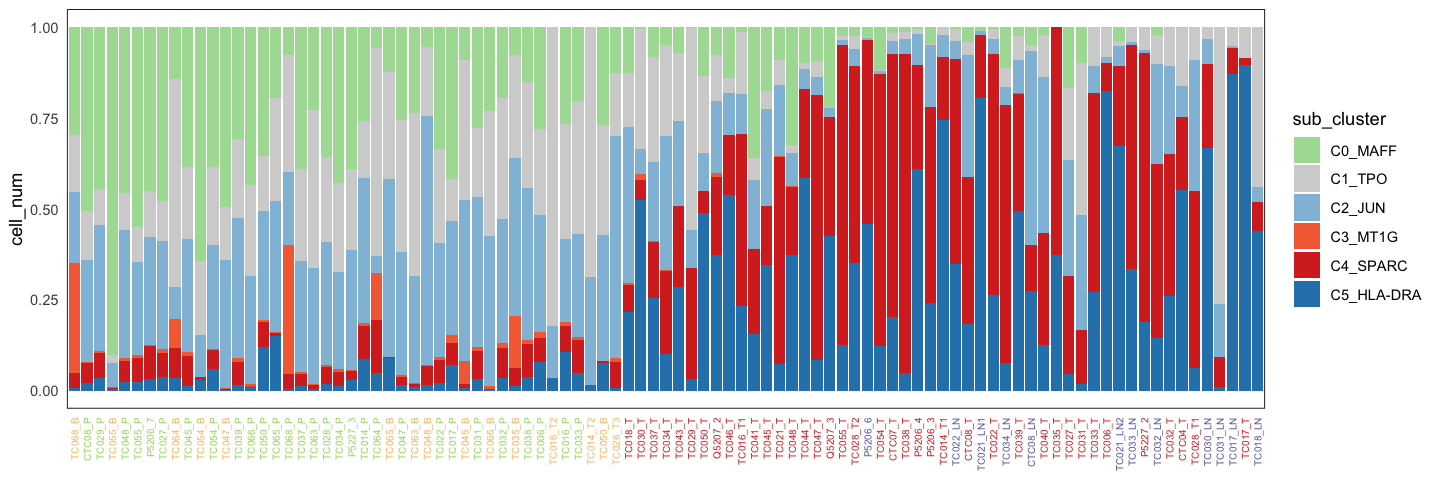

In [9]:

a=srt@meta.data %>%
  #filter(Coexisting_HT!='Yes')%>%
  group_by(orig.ident, sub_cluster, Tissue_desc) %>%
  summarise(cell_num=n()) %>%
  filter(orig.ident%in% sample_order$sample) %>%
  mutate(orig.ident=factor(orig.ident, levels = sample_order$sample)) %>%
  mutate(label_color=tissue_colors[Tissue_desc]) %>%
  mutate(orig.ident=paste0("<span style='color:",label_color,"'>",orig.ident,"</span>"),
         orig.ident=factor(orig.ident)) %>%
  #mutate(sub_cluster=factor(sub_cluster, levels=rev(c('Antigen presenting','EMT',  'Functional', 'Quiescent','ISG+', 'Stress', 'Aptosis'))))%>%
  ggplot(aes(x=orig.ident, y=cell_num, fill=sub_cluster)) +
  geom_bar(stat='identity', position = 'fill')+
  #scale_fill_igv()+
  scale_fill_manual(values = all_subtype_colors) +
  theme_minimal()+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        axis.title.x = element_blank(),
        panel.grid = element_blank(),
        axis.text.x = element_markdown(angle = 90, vjust = 0.5, hjust = 1, size=6)
  )
options(repr.plot.width=12, repr.plot.height=4)
a
ggsave(glue('{output_dir}/epithelial_cell_proportion_along_trajectory.pdf'), a,
       width=240, height=60, units='mm', dpi = 450, bg = 'transparent')


`summarise()` has grouped output by 'orig.ident', 'sub_cluster'. You can
override using the `.groups` argument.


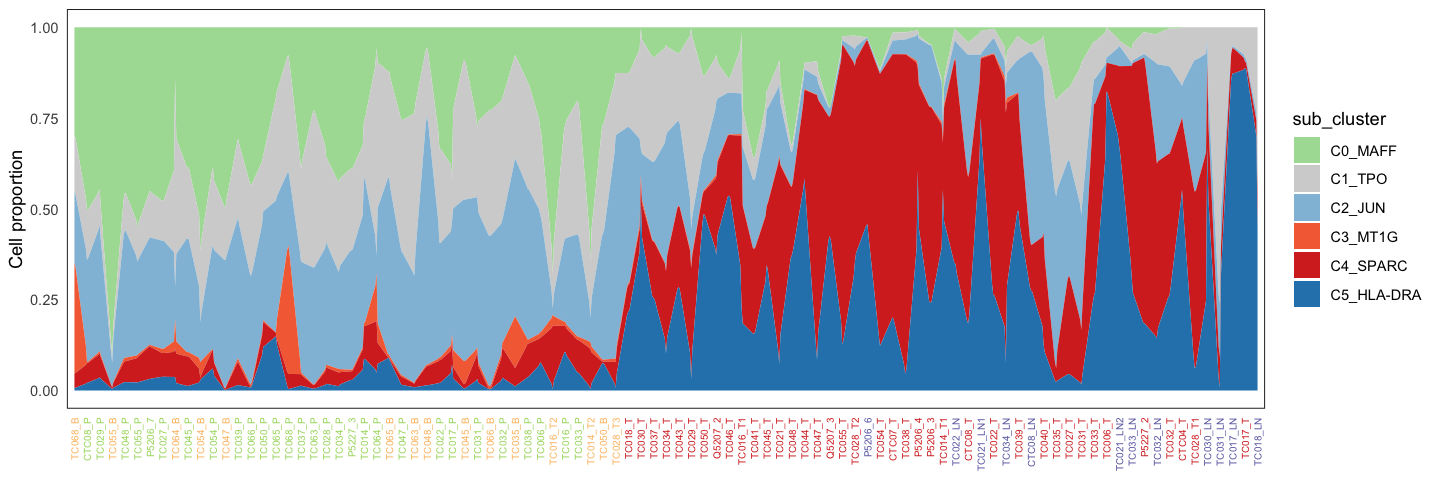

In [11]:
a=srt@meta.data %>%
  #filter(Coexisting_HT!='Yes')%>%
  group_by(orig.ident, sub_cluster, Tissue_desc) %>%
  summarise(cell_num=n()) %>%
  filter(orig.ident%in% sample_order$sample) %>%
  mutate(orig.ident=factor(orig.ident, levels = sample_order$sample)) %>%
  mutate(label_color=tissue_colors[Tissue_desc]) %>%
  mutate(orig.ident=paste0("<span style='color:",label_color,"'>",orig.ident,"</span>"),
         orig.ident=factor(orig.ident)) %>%
  ggplot(aes(x=orig.ident, y=cell_num, fill=sub_cluster, group = sub_cluster)) +
  geom_area(position='fill')+
  #scale_fill_igv()+
  labs(y='Cell proportion') +
  scale_fill_manual(values = all_subtype_colors) +
  theme_minimal()+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        axis.title.x = element_blank(),
        panel.grid = element_blank(),
        axis.text.x = element_markdown(angle = 90, vjust = 0.5, hjust = 1, size=6)
  )
options(repr.plot.width=12, repr.plot.height=4)
a
ggsave(glue('{output_dir}/epithelial_cell_proportion_along_trajectory2.pdf'), a,
       width=240, height=60, units='mm', dpi = 450, bg = 'transparent')

# 上皮细胞与轨迹相关scatter_plot

`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`
Joining with `by = join_by(sample)`


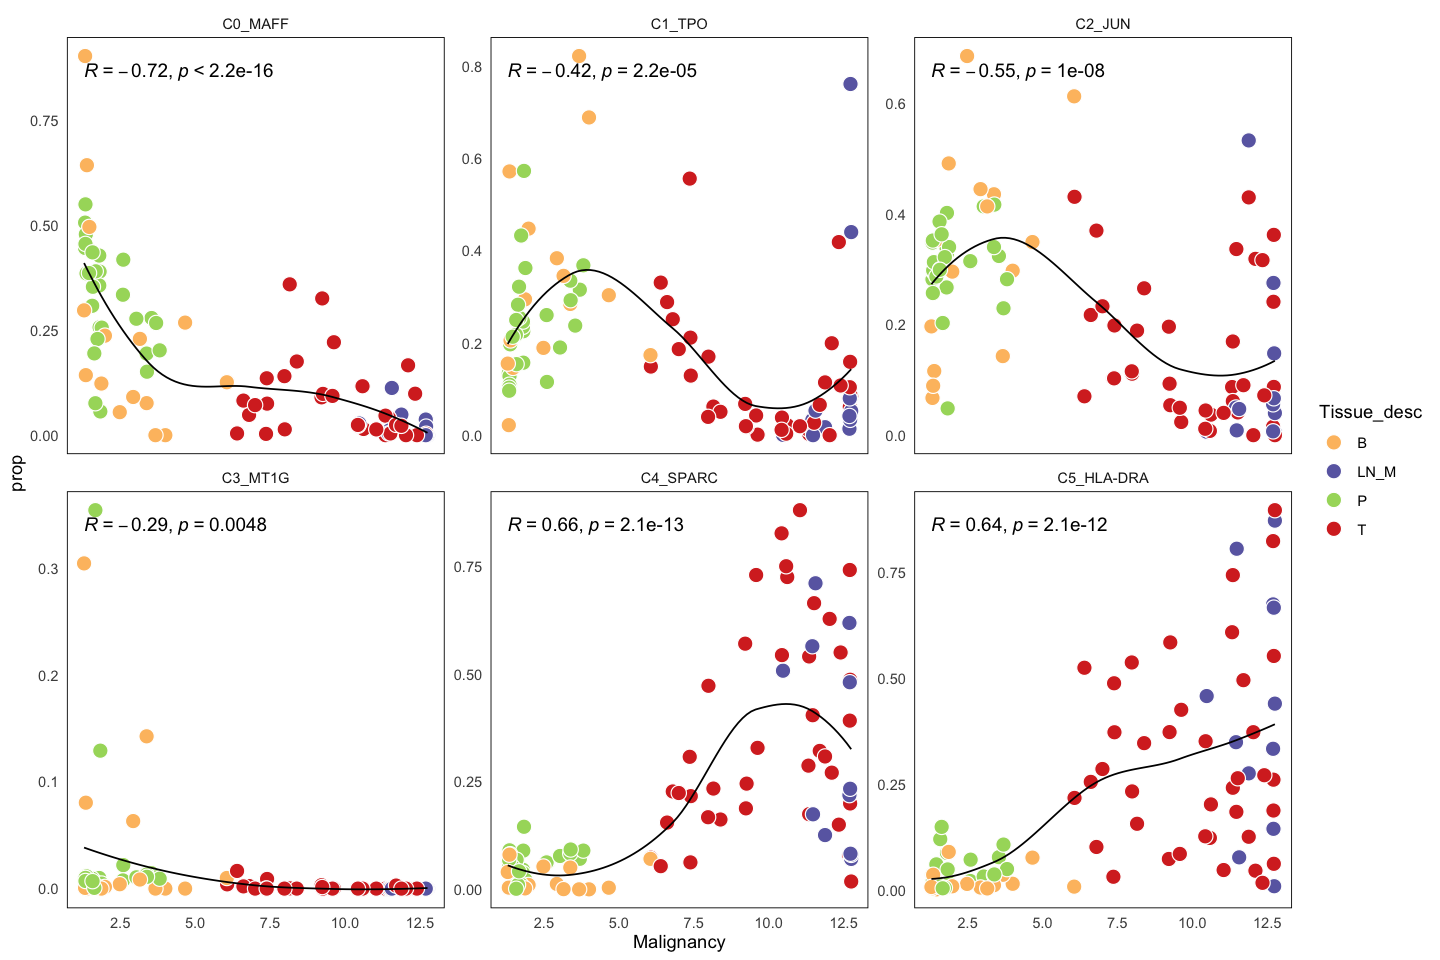

In [13]:
plot_data = srt %>%
  my_level_prop(levels='orig.ident',  group_by_name='sub_cluster', mutate_meta = c('Tissue_desc', 'patient')) %>%
  mutate(sample=orig.ident) %>%
  filter(orig.ident %in% sample_order$sample) %>%
  left_join(sample_order) 
#plot_data[,c('C4_score', 'C5_score')] = sample_score[plot_data$sample,c('C4_score', 'C5_score')]

#### scatter_plot ####
a=ggplot(plot_data, aes(x=Pseudotime, y=prop, fill=Tissue_desc))+
  geom_point(size=4, shape=21, color='white')+
  #scale_fill_manual(values=c('T'="#D51F26", 'LN_M'="#89288F", 'B'="#208A42", 'P'='gray')) + 
  scale_fill_manual(values = tissue_colors)+
  geom_smooth(data=plot_data,mapping = aes(x=Pseudotime, y=prop), method = "loess", se=F,  formula = y~x, size=0.5, inherit.aes = F, color='black')+
  stat_cor(data=plot_data,mapping = aes(x=Pseudotime, y=prop), method='pearson', size=4, inherit.aes = F)+
  facet_wrap(~sub_cluster, scales = 'free_y')+
  labs(x='Malignancy')+
  theme_minimal()+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        panel.grid = element_blank())
options(repr.plot.width=12, repr.plot.height=8)
a
ggsave(glue('{output_dir}/epithelial_cell_trajectory_scatter.pdf'), a,
       width=210, height=120, units='mm', dpi = 450, bg = 'transparent')

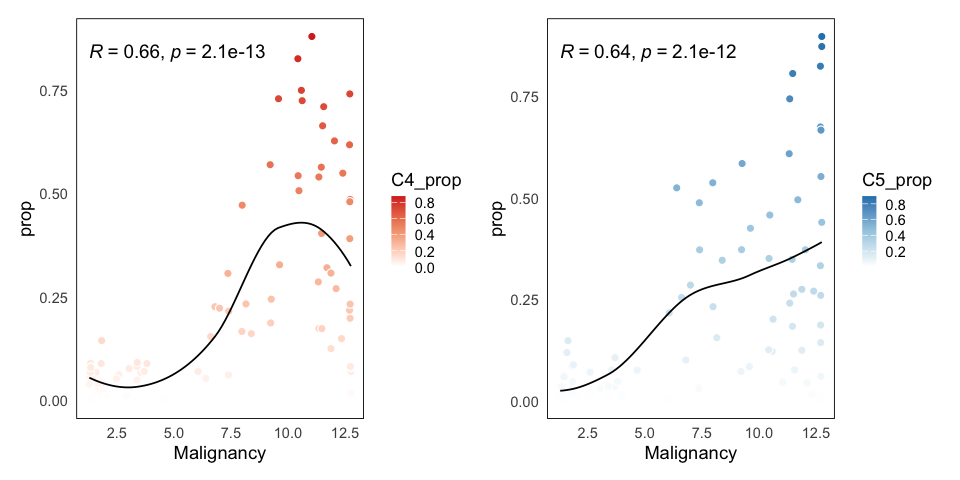

In [15]:
plot_data2 = plot_data %>% filter(sub_cluster%in%c('C4_SPARC'))
a=ggplot(plot_data2, aes(x=Pseudotime, y=prop, fill=prop))+
  geom_point(size=2, shape=21, color='white')+
  #scale_fill_manual(values=c('T'="#D51F26", 'LN_M'="#89288F", 'B'="#208A42", 'P'='gray')) + 
  #scale_fill_manual(values = tissue_colors)+
  scale_fill_gradientn(colours = c("#FFFFFF", "#F4A582", "#D73027"),name='C4_prop')+
  geom_smooth(data=plot_data2,mapping = aes(x=Pseudotime, y=prop), method = "loess", se=F,  formula = y~x, size=0.5, inherit.aes = F, color='black')+
  stat_cor(data=plot_data2,mapping = aes(x=Pseudotime, y=prop), method='pearson', size=4, inherit.aes = F)+
  #facet_wrap(~sub_cluster, scales = 'free_y')+
  theme_minimal()+
  labs(x='Malignancy')+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        panel.grid = element_blank(),
        legend.key.width = unit(3,'mm'),
        legend.key.height = unit(3,'mm'))
plot_data2 = plot_data %>% filter(sub_cluster%in%c('C5_HLA-DRA'))
b=ggplot(plot_data2, aes(x=Pseudotime, y=prop, fill=prop))+
  geom_point(size=2, shape=21, color='white')+
  #scale_fill_manual(values=c('T'="#D51F26", 'LN_M'="#89288F", 'B'="#208A42", 'P'='gray')) + 
  #scale_fill_manual(values = tissue_colors)+
  scale_fill_gradientn(colours = c("#FFFFFF", "#A6CEE3", "#2B83BA"),name='C5_prop')+
  geom_smooth(data=plot_data2,mapping = aes(x=Pseudotime, y=prop), method = "loess", se=F,  formula = y~x, size=0.5, inherit.aes = F, color='black')+
  stat_cor(data=plot_data2,mapping = aes(x=Pseudotime, y=prop), method='pearson', size=4, inherit.aes = F)+
  #facet_wrap(~sub_cluster, scales = 'free_y')+
  theme_minimal()+
  labs(x='Malignancy')+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        panel.grid = element_blank(),
        legend.key.width = unit(3,'mm'),
        legend.key.height = unit(3,'mm'))
options(repr.plot.width=8, repr.plot.height=4)
a+b

## C4C5评分

In [17]:
ph_marker = read.table('../output/87sampleEpithelial_P_markers.csv', sep=',')
C4_marker = ph_marker %>% filter(cluster=='C4_SPARC',p_val_adj<0.05, avg_log2FC>0)
C5_marker = ph_marker %>% filter(cluster=='C5_HLA-DRA',p_val_adj<0.05, avg_log2FC>0)

hallmark_data = GSEABase::getGmt('../h.all.v7.4.symbols.gmt')
hallmark_data = hallmark_data@.Data
hallmark_list = list()
for(i in hallmark_data){
  hallmark_list[[i@setName]] = i@geneIds
}

DefaultAssay(srt) = 'RNA'
srt = AddModuleScore(srt, features = list(C4_marker$gene, C5_marker$gene,
                                          hallmark_list$HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,
                                          hallmark_list$HALLMARK_INTERFERON_ALPHA_RESPONSE,
                                          hallmark_list$HALLMARK_INTERFERON_GAMMA_RESPONSE)
                     )


Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“The following features are not present in the object: WARS1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: WARS1, MARCHF1, not searching for symbol synonyms”


In [18]:
sample_score = srt@meta.data %>% 
  group_by(orig.ident) %>% 
  summarise(C4_score=mean(Cluster1),
            C5_score=mean(Cluster2),
            EMT_score=mean(Cluster3),
            INFa_score=mean(Cluster4),
            INFb_score=mean(Cluster5)) %>%
  as.data.frame()
rownames(sample_score) = sample_score$orig.ident

rownames(sample_order) = sample_order$sample
tmp_meta =srt@meta.data
tmp_meta$Pseudotime = sample_order[tmp_meta$orig.ident, 'Pseudotime']

tmp_pc_df = pc_df
tmp_pc_df[, c('C4_score', 'C5_score','EMT_score', 'INFa_score', 'INFb_score')] = sample_score[tmp_pc_df$sample, c('C4_score', 'C5_score','EMT_score', 'INFa_score', 'INFb_score')]


In [19]:

c=tmp_pc_df %>%
  #filter(sub_cluster=='C4_SPARC') %>%
  ggplot(aes(x=Pseudotime, y=C4_score))+
  geom_point(aes(fill=C4_score),size=2, shape=21, color='white') +
  geom_smooth(method = "loess", se=F,  formula = y~x, size=0.5,  color='black')+
  scale_fill_gradientn(colours = c("#FFFFFF", "#F4A582", "#D73027"),name='C4_score')+
  stat_cor(method='pearson', size=4)+
  theme_minimal()+
  labs(x='Malignancy')+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        panel.grid = element_blank(),
        legend.key.width = unit(3,'mm'),
        legend.key.height = unit(3,'mm')) 
d=tmp_pc_df %>%
  #filter(sub_cluster=='C4_SPARC') %>%
  ggplot(aes(x=Pseudotime, y=C5_score))+
  geom_point(aes(fill=C4_score),size=2, shape=21, color='white') +
  geom_smooth(method = "loess", se=F,  formula = y~x, size=0.5,  color='black')+
  scale_fill_gradientn(colours = c("#FFFFFF", "#A6CEE3", "#2B83BA"),name='C5_score')+
  stat_cor(method='pearson', size=4)+
  theme_minimal()+
  labs(x='Malignancy')+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        panel.grid = element_blank(),
        legend.key.width = unit(3,'mm'),
        legend.key.height = unit(3,'mm'))

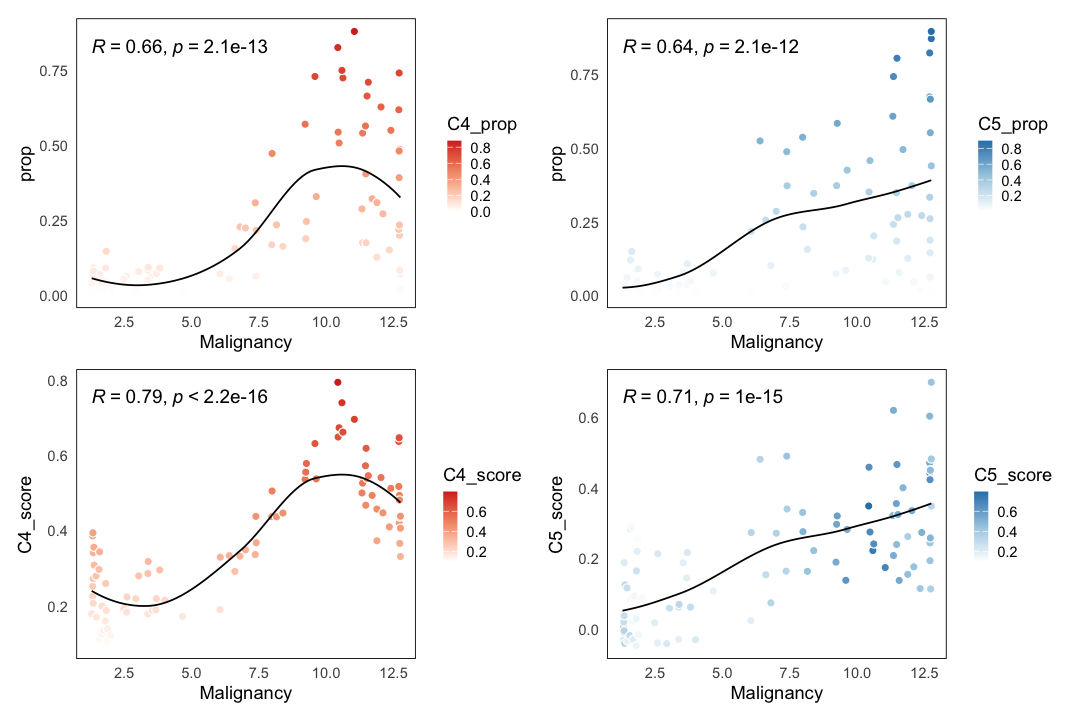

In [20]:
e = (a/c) | (b/d)
options(repr.plot.width=9, repr.plot.height=6)
e
ggsave(glue('{output_dir}/epithelial_cell_trajectory_scatter_C4C5.pdf'),e,
       width=180, height=120, units='mm', dpi = 450, bg = 'transparent')

In [21]:
plot_data = srt %>%
  my_level_prop(levels='orig.ident',  group_by_name='sub_cluster') %>%
  mutate(sample=orig.ident) %>%
  filter(orig.ident %in% sample_order$sample)
t1 = plot_data %>% filter(sub_cluster=='C4_SPARC')
rownames(t1) = t1$orig.ident
tmp_pc_df[, c('C4_prop')] = t1[tmp_pc_df$sample, 'prop']
t1 = plot_data %>% filter(sub_cluster=='C5_HLA-DRA')
rownames(t1) = t1$orig.ident
tmp_pc_df[, c('C5_prop')] = t1[tmp_pc_df$sample, 'prop']


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.


In [22]:

a_other=tmp_pc_df %>%
  #filter(sub_cluster=='C4_SPARC') %>%
  ggplot(aes(x=C5_prop, y=EMT_score))+
  geom_point(aes(fill=EMT_score),size=2, shape=21, color='white') +
  geom_smooth(method = "loess", se=F,  formula = y~x, size=0.5,  color='black')+
  scale_fill_gradientn(colours = c("#FFFFFF", "#F4A582", "#D73027"),name='EMT_score')+
  stat_cor( method='pearson', size=4)+
  theme_minimal()+
  labs(x='C5 proportion')+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        panel.grid = element_blank(),
        legend.key.width = unit(3,'mm'),
        legend.key.height = unit(3,'mm')) 
a1=tmp_pc_df %>%
  #filter(sub_cluster=='C4_SPARC') %>%
  ggplot(aes(x=C4_prop, y=EMT_score))+
  geom_point(aes(fill=EMT_score),size=2, shape=21, color='white') +
  geom_smooth(method = "loess", se=F,  formula = y~x, size=0.5,  color='black')+
  scale_fill_gradientn(colours = c("#FFFFFF", "#F4A582", "#D73027"),name='EMT_score')+
  stat_cor( method='pearson', size=4)+
  theme_minimal()+
  labs(x='C4 proportion')+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        panel.grid = element_blank(),
        legend.key.width = unit(3,'mm'),
        legend.key.height = unit(3,'mm')) 

b1=tmp_pc_df %>%
  #filter(sub_cluster=='C4_SPARC') %>%
  ggplot(aes(x=C4_prop, y=INFa_score))+
  geom_point(aes(fill=INFa_score),size=2, shape=21, color='white') +
  geom_smooth(method = "loess", se=F,  formula = y~x, size=0.5,  color='black')+
  scale_fill_gradientn(colours = c("#FFFFFF", "#A6CEE3", "#2B83BA"),name='INF_alpha')+
  stat_cor( method='pearson', size=4)+
  theme_minimal()+
  labs(x='C5 proportion', y='IFN alpha score')+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        panel.grid = element_blank(),
        legend.key.width = unit(3,'mm'),
        legend.key.height = unit(3,'mm')) 
c1=tmp_pc_df %>%
  #filter(sub_cluster=='C4_SPARC') %>%
  ggplot(aes(x=C4_prop, y=INFb_score))+
  geom_point(aes(fill=INFb_score),size=2, shape=21, color='white') +
  geom_smooth(method = "loess", se=F,  formula = y~x, size=0.5,  color='black')+
  scale_fill_gradientn(colours = c("#FFFFFF", "#A6CEE3", "#2B83BA"),name='INF_gamma')+
  stat_cor( method='pearson', size=4)+
  theme_minimal()+
  labs(x='C5 proportion', y='IFN gamma score')+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        panel.grid = element_blank(),
        legend.key.width = unit(3,'mm'),
        legend.key.height = unit(3,'mm')) 
abc = ((a/b/c)|(a1/b1/c1))+patchwork::plot_layout(guides = 'collect')

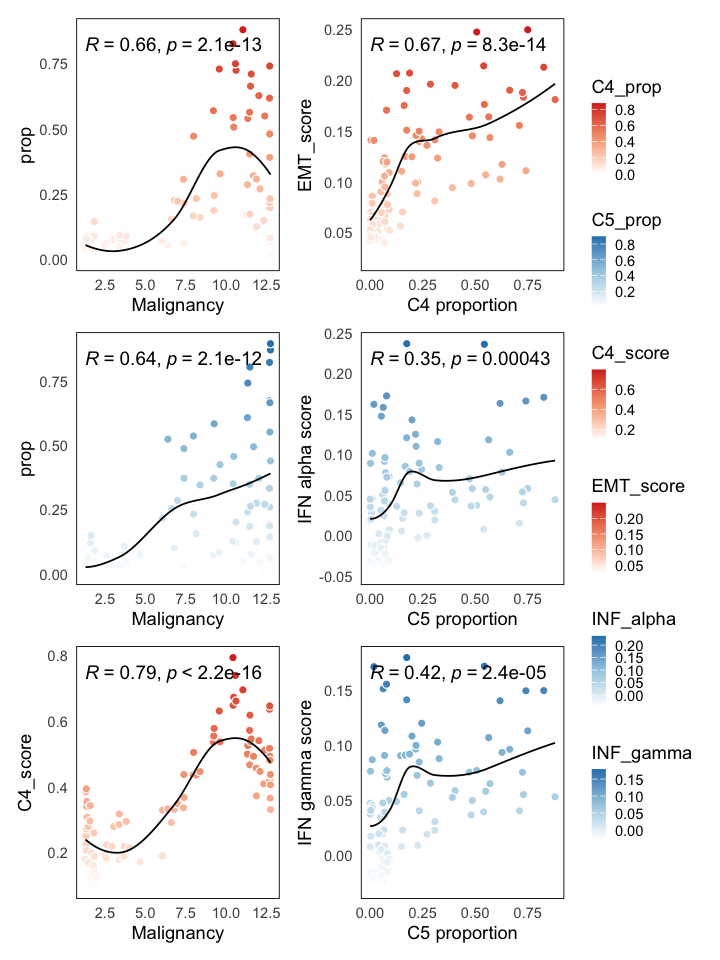

In [23]:
options(repr.plot.width=6, repr.plot.height=8) 
abc
ggsave(glue('{output_dir}/epithelial_cell_trajectory_scatter_function评分2.pdf'),abc,
       width=150, height=160, units='mm', dpi = 450, bg = 'transparent')

## C4C5在转移中的比较

In [26]:
plot_data = srt %>%
  my_level_prop(levels='orig.ident',  group_by_name='sub_cluster', mutate_meta = c('Tissue_desc', 'patient','Tumor_metastasis')) %>%
  mutate(sample=orig.ident) %>%
  filter(orig.ident %in% sample_order$sample) %>%
  left_join(sample_order) 


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`
Joining with `by = join_by(sample)`


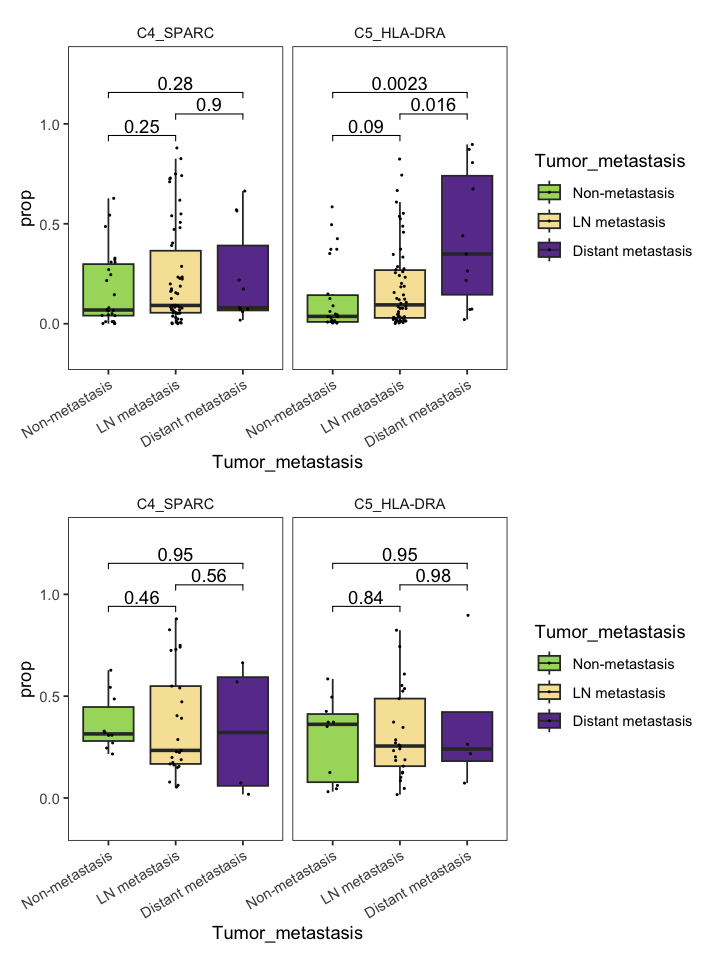

In [27]:
a1 = plot_data %>%
  filter(sub_cluster%in%c('C4_SPARC', 'C5_HLA-DRA')) %>%
  mutate(Tumor_metastasis=factor(Tumor_metastasis, c('Non-metastasis', 'LN metastasis','Distant metastasis'))) %>%
  ggplot(aes(x=Tumor_metastasis,y=prop, fill=Tumor_metastasis))+
  geom_boxplot(outlier.shape = NA, size=0.5)+
  scale_fill_manual(values = tissue_colors) +
  geom_jitter(width=0.1, size=0.2)+
  facet_wrap(~sub_cluster)+
  stat_compare_means(comparisons = list(c('Non-metastasis', 'LN metastasis'),
                                        c('Distant metastasis', 'LN metastasis'),
                                        c('Distant metastasis', 'Non-metastasis')))+
  scale_y_continuous(expand = c(0.2,0))+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 30, hjust = 1,vjust = 1),
        strip.background = element_blank())
a2 =  plot_data %>%
  filter(Tissue_desc=='T') %>%
  filter(sub_cluster%in%c('C4_SPARC', 'C5_HLA-DRA')) %>%
  mutate(Tumor_metastasis=factor(Tumor_metastasis, c('Non-metastasis', 'LN metastasis','Distant metastasis'))) %>%
  ggplot(aes(x=Tumor_metastasis,y=prop, fill=Tumor_metastasis))+
  geom_boxplot(outlier.shape = NA, size=0.5)+
  scale_fill_manual(values = tissue_colors) +
  geom_jitter(width=0.1, size=0.2)+
  facet_wrap(~sub_cluster)+
  stat_compare_means(comparisons = list(c('Non-metastasis', 'LN metastasis'),
                                        c('Distant metastasis', 'LN metastasis'),
                                        c('Distant metastasis', 'Non-metastasis')))+
  scale_y_continuous(expand = c(0.2,0))+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 30, hjust = 1,vjust = 1),
        strip.background = element_blank())
options(repr.plot.width=6, repr.plot.height=8)
a1/a2
ggsave(glue('{output_dir}/C4C比例在metastasis中比较.pdf'),a1/a2,
       width=140, height=160, units='mm', dpi = 450, bg = 'transparent')

In [28]:
tmp_meta = plot_data[, c('orig.ident', 'Tumor_metastasis')] %>% unique()
rownames(tmp_meta) = tmp_meta$orig.ident

tmp_pc_df2 = tmp_pc_df
tmp_pc_df2$Tumor_metastasis =tmp_meta[tmp_pc_df2$sample, 'Tumor_metastasis']
a1 = tmp_pc_df2 %>%
  mutate(Tumor_metastasis=factor(Tumor_metastasis, c('Non-metastasis', 'LN metastasis','Distant metastasis'))) %>%
  ggplot(aes(x=Tumor_metastasis,y=C4_score, fill=Tumor_metastasis))+
  geom_boxplot(outlier.shape = NA, size=0.5)+
  scale_fill_manual(values = tissue_colors) +
  geom_jitter(width=0.1, size=0.2)+
  stat_compare_means(comparisons = list(c('Non-metastasis', 'LN metastasis'),
                                        c('Distant metastasis', 'LN metastasis'),
                                        c('Distant metastasis', 'Non-metastasis')))+
  scale_y_continuous(expand = c(0.2,0))+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 30, hjust = 1,vjust = 1),
        strip.background = element_blank())
a2 = tmp_pc_df2 %>%
  mutate(Tumor_metastasis=factor(Tumor_metastasis, c('Non-metastasis', 'LN metastasis','Distant metastasis'))) %>%
  ggplot(aes(x=Tumor_metastasis,y=C5_score, fill=Tumor_metastasis))+
  geom_boxplot(outlier.shape = NA, size=0.5)+
  scale_fill_manual(values = tissue_colors) +
  geom_jitter(width=0.1, size=0.2)+
  stat_compare_means(comparisons = list(c('Non-metastasis', 'LN metastasis'),
                                        c('Distant metastasis', 'LN metastasis'),
                                        c('Distant metastasis', 'Non-metastasis')))+
  scale_y_continuous(expand = c(0.2,0))+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 30, hjust = 1,vjust = 1),
        strip.background = element_blank())

a3 = tmp_pc_df2 %>%
  filter(Tissue_desc=='T') %>%
  mutate(Tumor_metastasis=factor(Tumor_metastasis, c('Non-metastasis', 'LN metastasis','Distant metastasis'))) %>%
  ggplot(aes(x=Tumor_metastasis,y=C4_score, fill=Tumor_metastasis))+
  geom_boxplot(outlier.shape = NA, size=0.5)+
  scale_fill_manual(values = tissue_colors) +
  geom_jitter(width=0.1, size=0.2)+
  stat_compare_means(comparisons = list(c('Non-metastasis', 'LN metastasis'),
                                        c('Distant metastasis', 'LN metastasis'),
                                        c('Distant metastasis', 'Non-metastasis')))+
  scale_y_continuous(expand = c(0.2,0))+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 30, hjust = 1,vjust = 1),
        strip.background = element_blank())
a4 = tmp_pc_df2 %>%
  filter(Tissue_desc=='T') %>%
  mutate(Tumor_metastasis=factor(Tumor_metastasis, c('Non-metastasis', 'LN metastasis','Distant metastasis'))) %>%
  ggplot(aes(x=Tumor_metastasis,y=C5_score, fill=Tumor_metastasis))+
  geom_boxplot(outlier.shape = NA, size=0.5)+
  scale_fill_manual(values = tissue_colors) +
  geom_jitter(width=0.1, size=0.2)+
  stat_compare_means(comparisons = list(c('Non-metastasis', 'LN metastasis'),
                                        c('Distant metastasis', 'LN metastasis'),
                                        c('Distant metastasis', 'Non-metastasis')))+
  scale_y_continuous(expand = c(0.2,0))+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 30, hjust = 1,vjust = 1),
        strip.background = element_blank())


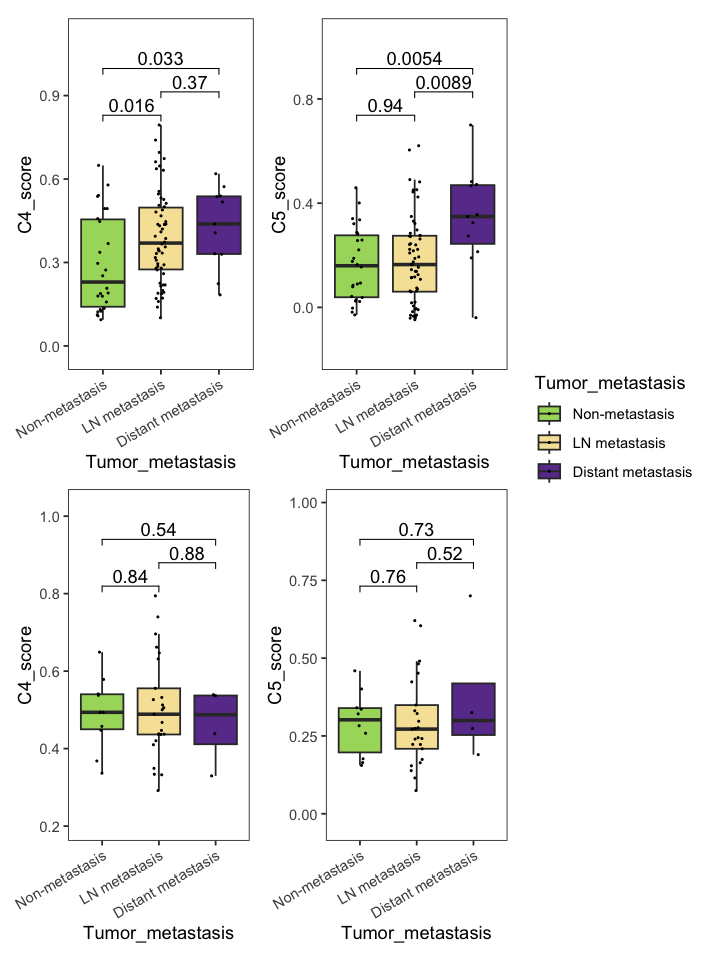

In [29]:

aa = (a1|a2) / (a3|a4)+ patchwork::plot_layout(guides='collect')
options(repr.plot.width=6, repr.plot.height=8)
aa
ggsave(glue('{output_dir}/C4C评分在metastasis中比较.pdf'),aa,
       width=140, height=160, units='mm', dpi = 450, bg = 'transparent')


## cytotrace

Warning message:
“Removed 108715 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 108715 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 108715 rows containing non-finite outside the scale range
(`stat_signif()`).”
Warning message:
“Removed 108715 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 108715 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 108715 rows containing non-finite outside the scale range
(`stat_signif()`).”


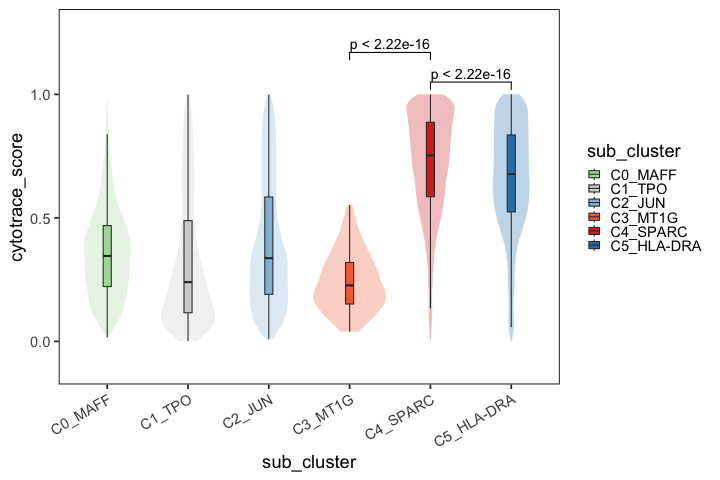

In [30]:

results = readRDS('../Thyroid_code/Cytotrace/肿瘤_cytotrace_result.rds')
same_bc = intersect(colnames(srt), names(results$CytoTRACE))
srt[['cytotrace_score']] = NA
srt@meta.data[same_bc, 'cytotrace_score'] = results$CytoTRACE[same_bc]
a=srt@meta.data %>%
  #filter(!is.na(srt$cytotrace_score))+
  ggplot(aes(x=sub_cluster, y=cytotrace_score,fill = sub_cluster))+
  geom_violin(size=NA, alpha=0.3, show.legend = F)+
  geom_boxplot(outlier.shape = NA, width=0.1, size=0.3)+
  scale_fill_manual(values = Epithelial_color)+
  stat_compare_means(comparisons = list(c('C4_SPARC','C5_HLA-DRA'),
                                        c('C4_SPARC','C3_MT1G')), size=3)+
  scale_y_continuous(expand = c(0.15,0))+
  theme_bw()+
  theme(panel.border = element_rect(color='black', fill=NA),
        strip.background = element_blank(),
        axis.text.x = element_text(angle = 30, hjust = 1,vjust=1),
        panel.grid = element_blank(),
        legend.key.width = unit(3,'mm'),
        legend.key.height = unit(3,'mm'))
options(repr.plot.width=6, repr.plot.height=4)
a
ggsave(glue('{output_dir}/epithelial_cell_cytotrace_score.pdf'),a,
       width=100, height=60, units='mm', dpi = 450, bg = 'transparent')

# 亚群注释

In [34]:
ph_marker = read.table('../output/87sampleEpithelial_P_markers.csv', sep=',')
hallmark_data = GSEABase::getGmt('../h.all.v7.4.symbols.gmt')
hallmark_data = hallmark_data@.Data
hallmark_list = list()
for(i in hallmark_data){
  hallmark_list[[i@setName]] = i@geneIds
}
res = enrich_with_marker(ph_marker, hallmark_list)

library(seriation)
register_DendSer()
o=seriate(res,margin = 1, method='Heatmap', seriation_method='Dendser_BAR', dist_fun=dist)
cutree(o[[1]],6)
res2 = res[get_order(o,1),]
ht = Heatmap(res, 
        cluster_rows = F, 
        cluster_columns = F, 
        row_split = factor(cutree(o[[1]],6), c(1,3,6,5,2,4))
        )
res3 = res[unlist(row_order(ht)),]
rownames(res3) = gsub('HALLMARK_','',rownames(res3))
ht2 = Heatmap(res3, 
        cluster_rows = F, 
        cluster_columns = F,
        col=circlize::colorRamp2(c(-2,-1,0,1,2), c("#E0F3F8", "#91BFDB", "#FFFFFF", "#FC8D59", "#D73027")),
        row_names_gp = gpar(fontsize=6),
        column_names_gp = gpar(fontsize=6),
        heatmap_legend_param = list('title'='EnrichScore')
)
pdf(glue('{output_dir}/subcluster_annotation.pdf'), width=4, height=4)
draw(ht2)
dev.off()

Registered S3 method overwritten by 'gclus':
  method         from     
  reorder.hclust seriation

Registering new seriation method ‘DendSer’ for ‘dist’register_DendSer()

Registering new seriation method ‘DendSer_BAR’ for ‘dist’register_DendSer()

Registering new seriation method ‘DendSer_PL’ for ‘dist’register_DendSer()

Registering new seriation method ‘DendSer_LPL’ for ‘dist’register_DendSer()

Registering new seriation method ‘DendSer_ARc’ for ‘dist’register_DendSer()

Registering new seriation criteron ‘ARc’ for ‘dist’ using register_DendSer()



HALLMARK_TNFA_SIGNALING_VIA_NFKB 
                                         1 
                          HALLMARK_HYPOXIA 
                                         1 
          HALLMARK_CHOLESTEROL_HOMEOSTASIS 
                                         2 
               HALLMARK_TGF_BETA_SIGNALING 
                                         3 
          HALLMARK_IL6_JAK_STAT3_SIGNALING 
                                         4 
                   HALLMARK_G2M_CHECKPOINT 
                                         5 
                        HALLMARK_APOPTOSIS 
                                         2 
                     HALLMARK_ADIPOGENESIS 
                                         1 
          HALLMARK_ESTROGEN_RESPONSE_EARLY 
                                         3 
           HALLMARK_ESTROGEN_RESPONSE_LATE 
                                         2 
                HALLMARK_ANDROGEN_RESPONSE 
                                         4 
                       HALLMARK_MYOGENESIS 
                                         3 
                HALLMARK_PROTEIN_SECRETION 
                                         5 
        HALLMARK_INTERFERON_ALPHA_RESPONSE 
                                         4 
        HALLMARK_INTERFERON_GAMMA_RESPONSE 
                                         4 
                  HALLMARK_APICAL_JUNCTION 
                                         1 
                   HALLMARK_APICAL_SURFACE 
                                         2 
                       HALLMARK_COMPLEMENT 
                                         4 
        HALLMARK_UNFOLDED_PROTEIN_RESPONSE 
                                         1 
          HALLMARK_PI3K_AKT_MTOR_SIGNALING 
                                         1 
                 HALLMARK_MTORC1_SIGNALING 
                                         5 
                      HALLMARK_E2F_TARGETS 
                                         1 
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 
                                         2 
            HALLMARK_INFLAMMATORY_RESPONSE 
                                         1 
            HALLMARK_XENOBIOTIC_METABOLISM 
                                         5 
            HALLMARK_FATTY_ACID_METABOLISM 
                                         5 
        HALLMARK_OXIDATIVE_PHOSPHORYLATION 
                                         3 
                       HALLMARK_GLYCOLYSIS 
                                         6 
  HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY 
                                         6 
                      HALLMARK_P53_PATHWAY 
                                         5 
                   HALLMARK_UV_RESPONSE_UP 
                                         6 
                   HALLMARK_UV_RESPONSE_DN 
                                         6 
                      HALLMARK_COAGULATION 
                                         5 
              HALLMARK_IL2_STAT5_SIGNALING 
                                         1 
             HALLMARK_BILE_ACID_METABOLISM 
                                         3 
                       HALLMARK_PEROXISOME 
                                         3 
              HALLMARK_ALLOGRAFT_REJECTION 
                                         4 
                HALLMARK_KRAS_SIGNALING_UP 
                                         1 
                HALLMARK_KRAS_SIGNALING_DN 
                                         4

Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”


pdf 
  2

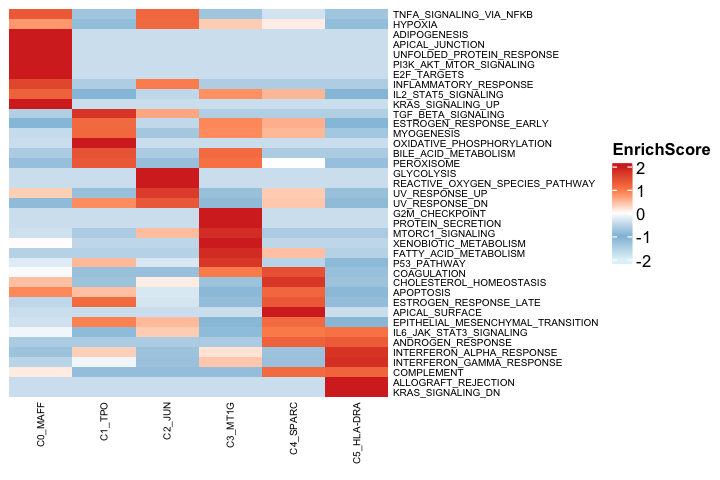

In [35]:
draw(ht2)

# C4C5与免疫的相关性

In [36]:
srt_meta = read.table('../all_srt_meta97.txt', sep='\t', header=T)

In [44]:
rownames(pc_df) = pc_df$sample

In [45]:

srt_meta[srt_meta$Cluster=='LEC', 'sub_cluster'] = 'LEC'
srt_meta[['CellType']] = srt_meta$Cluster
srt_meta[srt_meta$sub_cluster=='Plasma', 'CellType'] = 'Plasma'
srt_meta[srt_meta$sub_cluster=='Mast', 'CellType'] = 'Mast'
srt_meta[srt_meta$sub_cluster=='pDC', 'CellType'] = 'pDC'

srt2_meta = srt_meta[, c('sub_cluster', 'Cluster')] %>% distinct()
rownames(srt2_meta) = srt2_meta$sub_cluster

srt_meta$Pseudotime = pc_df[srt_meta$orig.ident, 'Pseudotime']

In [46]:
other_prop3 =  c()
for(cl in unique(srt_meta$Cluster)){
  print(cl)
  #tmp_srt = subset(srt2, Cluster==cl)
  tmp_srt = srt_meta[srt_meta$Cluster==cl,]
  tmp_prop = tmp_srt %>% my_level_prop(levels='orig.ident', 
                                       group_by_name='sub_cluster',
                                       mutate_meta = c('Tissue_desc', 'patient', 'Pseudotime'),
                                       obj_is_meta = T)
  other_prop3 = rbind(other_prop3, tmp_prop)
}

[1] "Tcell"


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`


[1] "Bcell"


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`


[1] "Myeloid"


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`


[1] "Endothelial"


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`


[1] "Epithelial"


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`


[1] "Fibroblast"


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`


[1] "LEC"


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 68 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 68 rows containing non-finite outside the scale range (`stat_cor()`).”
Warning message:
“Removed 68 rows containing missing values or values outside the scale range
(`geom_point()`).”


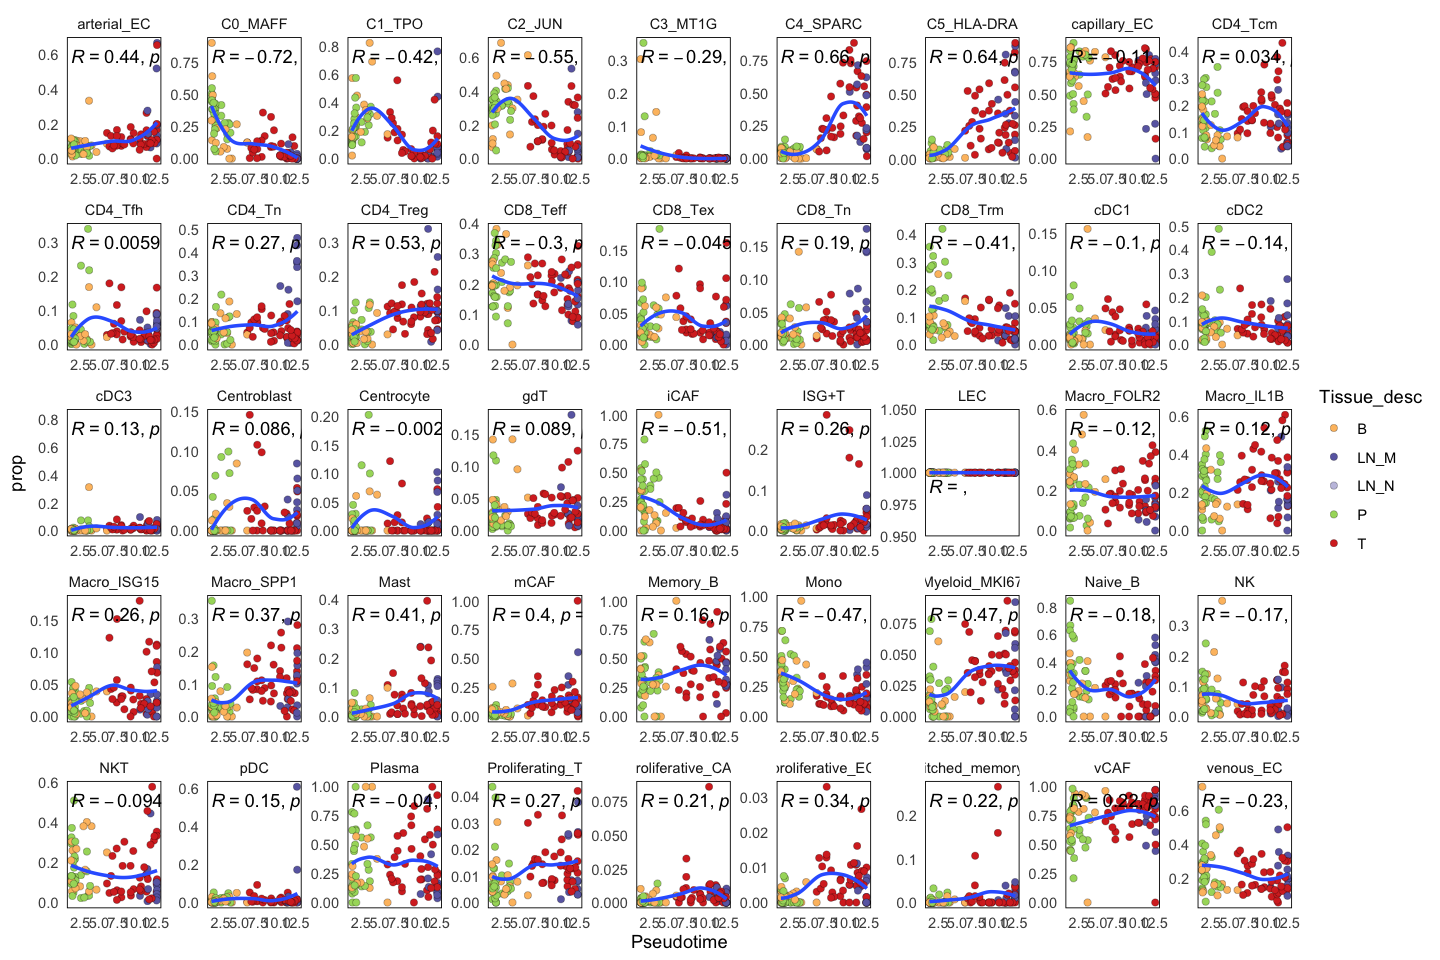

In [50]:
a=other_prop3 %>%
  #filter(Tissue_desc=='T') %>%
  #filter(Coexisting_HT=='No') %>%
  ggplot(aes(x=Pseudotime, y=prop)) +
  geom_point(aes(fill=Tissue_desc),size=2, shape=21, color='black', alpha=1, stroke=0.1) +
  #scale_fill_igv()+
  scale_fill_manual(values = tissue_colors)+
  geom_smooth(se=F)+
  stat_cor()+
  facet_wrap(~sub_cluster, nrow=5, scales = 'free')+
  theme_minimal()+
  theme(panel.border = element_rect(color='black', fill=NA),
        panel.grid = element_blank())
options(repr.plot.width=12, repr.plot.height=8)
a

In [49]:
ggsave(glue('{output_dir}/全部亚型与轨迹相关scatter_plot.pdf'),a,
       width=20, height = 12, units='in', dpi = 450, bg = 'transparent')


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 68 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 68 rows containing non-finite outside the scale range (`stat_cor()`).”
Warning message:
“Removed 68 rows containing missing values or values outside the scale range
(`geom_point()`).”


Warning message in cor(x, y):
“the standard deviation is zero”


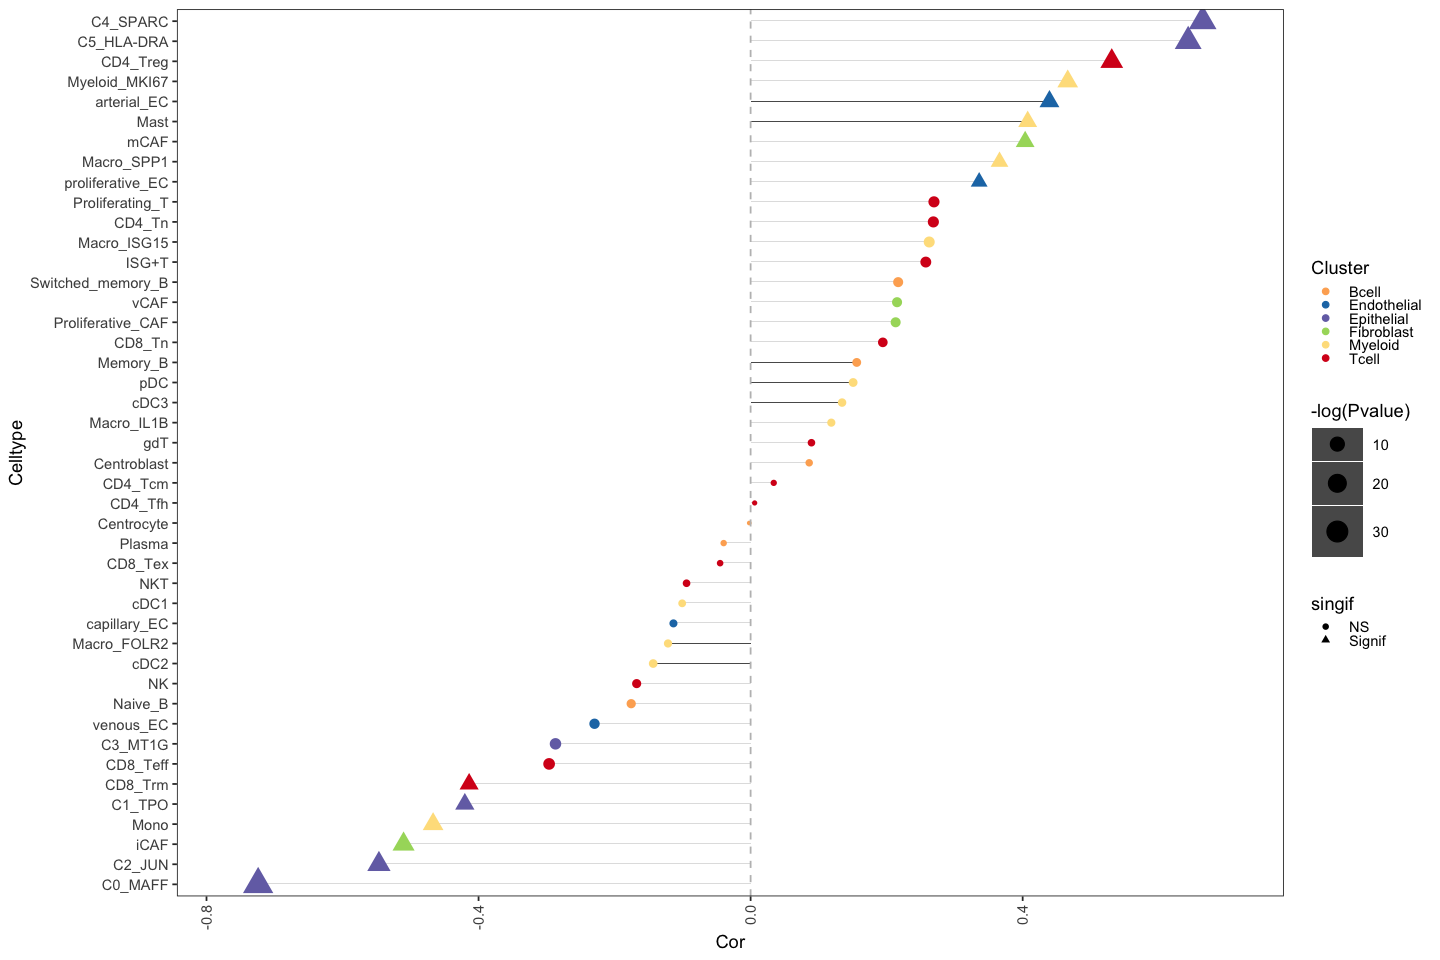

In [51]:
mal_cor = c()
imm_cells =  unique(srt_meta$sub_cluster)
for(ic in imm_cells){
  tmp_imm = other_prop3[other_prop3$sub_cluster==ic, ]
  ct= cor.test(tmp_imm$Pseudotime, tmp_imm$prop)
  mal_cor = rbind(mal_cor, c(ic, ct$estimate, ct$p.value))
}

mal_cor = as.data.frame(mal_cor)
colnames(mal_cor) = c('Celltype', 'Cor', 'Pvalue')
mal_cor$Cor = as.numeric(mal_cor$Cor)
mal_cor$Pvalue = as.numeric(mal_cor$Pvalue)
mal_cor$Cluster = srt2_meta[mal_cor$Celltype, 'Cluster']

#mal_cor$singif = ifelse((mal_cor$Cor>0.3) | (mal_cor$Cor<(-0.3)), 'Signif', 'NS')
mal_cor$singif = ifelse(mal_cor$Pvalue<0.001, 'Signif', 'NS')

b=mal_cor%>%
  filter(Cluster!='LEC') %>%
  filter(Celltype!='Endothelial') %>%
  mutate(Celltype=fct_reorder(Celltype, Cor)) %>%
  #filter(Epi%in%c('C5_HLA-DRA', 'C4_SPARC')) %>%
  ggplot(aes(x=Celltype, y=Cor, size=-log(Pvalue), color=Cluster, shape=singif))+
  geom_col(width=0.01, color=NA)+
  geom_point()+
  geom_hline(yintercept = 0, color='gray', linetype='dashed')+
  scale_color_manual(values = all_subtype_colors)+
  #scale_color_igv()+
  #scale_color_gradientn(colours = c('blue', 'white', 'red'))+#, limits=c(-1,1))+
  #facet_wrap(~Cluster, scales = 'free_x', nrow=1)+
  scale_y_continuous(expand = c(0.05,0.05))+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 90, hjust = 1,vjust = 0.5),
        legend.key.height = unit(1,'mm'))+
  coord_flip()
b

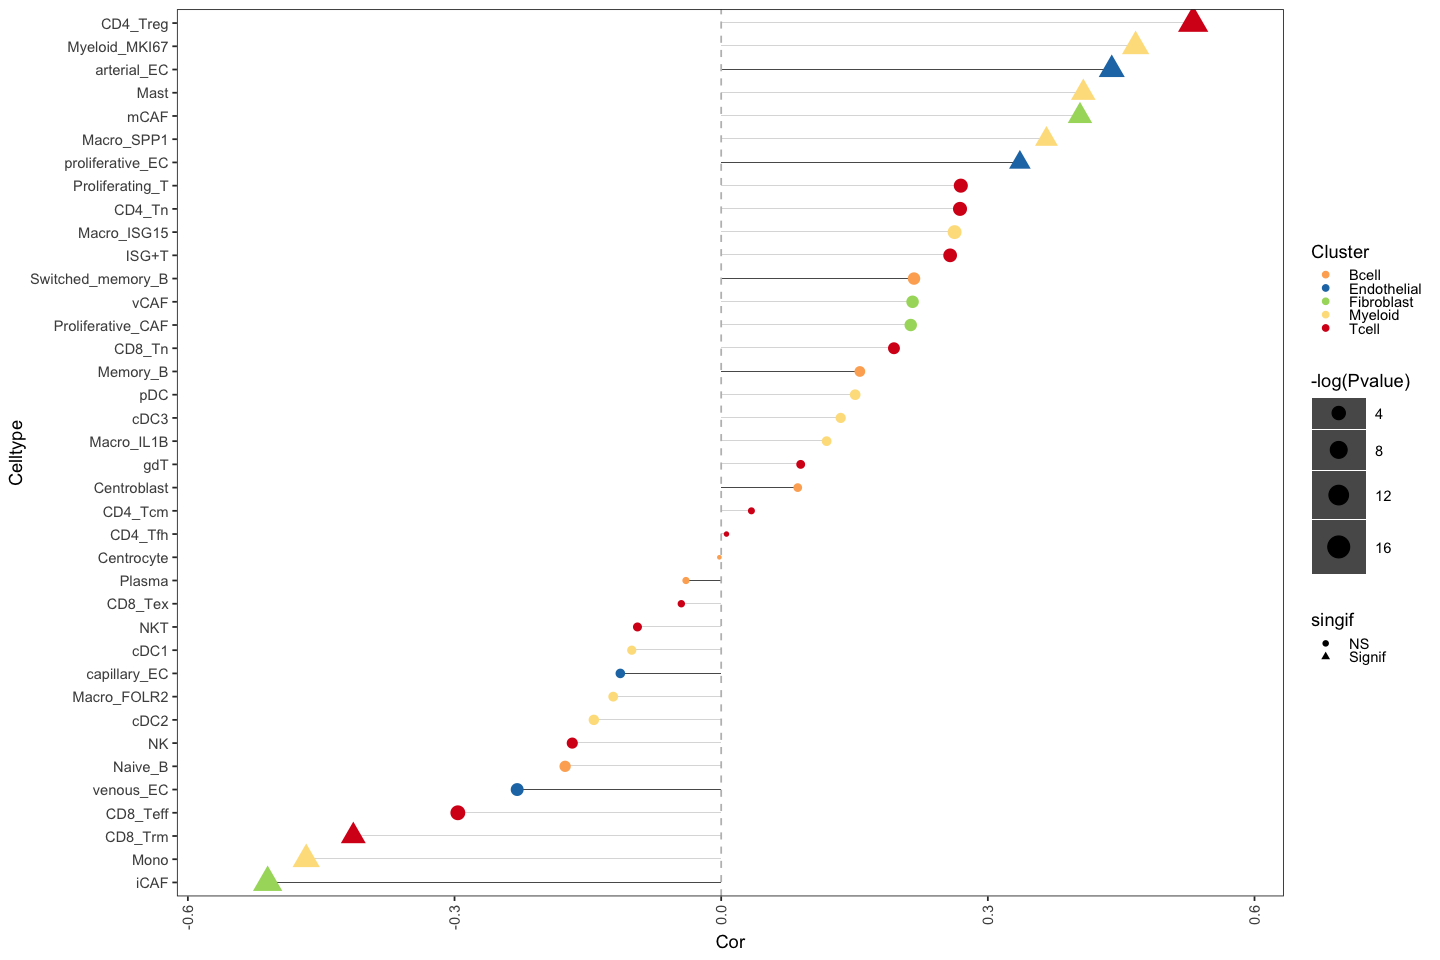

In [ ]:
# 没有epithelial
b=mal_cor%>%
  filter(Cluster!='LEC') %>%
  filter(Cluster!='Epithelial') %>%
  mutate(Celltype=fct_reorder(Celltype, Cor)) %>%
  #filter(Epi%in%c('C5_HLA-DRA', 'C4_SPARC')) %>%
  ggplot(aes(x=Celltype, y=Cor, size=-log(Pvalue), color=Cluster, shape=singif))+
  geom_col(width=0.01, color=NA)+
  geom_point()+
  geom_hline(yintercept = 0, color='gray', linetype='dashed')+
  scale_color_manual(values = all_subtype_colors)+
  #scale_color_igv()+
  #scale_color_gradientn(colours = c('blue', 'white', 'red'))+#, limits=c(-1,1))+
  #facet_wrap(~Cluster, scales = 'free_x', nrow=1)+
  scale_y_continuous(expand = c(0.05,0.05))+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 90, hjust = 1,vjust = 0.5),
        legend.key.height = unit(1,'mm'))+
  coord_flip()
b

## 上皮与免疫细胞比例

In [53]:
Epi_Imm_cor = c()
epi_cells = unique(srt_meta[srt_meta$Cluster=='Epithelial',]$sub_cluster)
imm_cells = unique(srt_meta[srt_meta$Cluster!='Epithelial',]$sub_cluster)
for(ec in epi_cells){
  tmp_epi = other_prop3[other_prop3$sub_cluster==ec, ]
  tmp_epi_prop = tmp_epi$prop
  names(tmp_epi_prop) = tmp_epi$orig.ident
  for(ic in imm_cells){
    tmp_imm = other_prop3[other_prop3$sub_cluster==ic, ]
    rownames(tmp_imm) = tmp_imm$orig.ident
    ct= cor.test(tmp_epi_prop, tmp_imm[names(tmp_epi_prop), 'prop'])
    Epi_Imm_cor = rbind(Epi_Imm_cor, c(ec, ic, ct$estimate, ct$p.value))
  }
}
Epi_Imm_cor = as.data.frame(Epi_Imm_cor)
colnames(Epi_Imm_cor) = c('Epi', 'Imm', 'Cor', 'Pvalue')
Epi_Imm_cor$Cor = as.numeric(Epi_Imm_cor$Cor)
Epi_Imm_cor$Pvalue = as.numeric(Epi_Imm_cor$Pvalue)
Epi_Imm_cor$Cluster = srt2_meta[Epi_Imm_cor$Imm, 'Cluster']
#Epi_Imm_cor$singif = ifelse(Epi_Imm_cor$Cor>0.3, 'Signif', 'NS')
Epi_Imm_cor$singif = ifelse(Epi_Imm_cor$Pvalue<0.001, 'Signif', 'NS')

Epi_Imm_cor[Epi_Imm_cor$Imm %in% mal_cor[mal_cor$singif=='NS','Celltype'],'singif'] = 'NS'


Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”


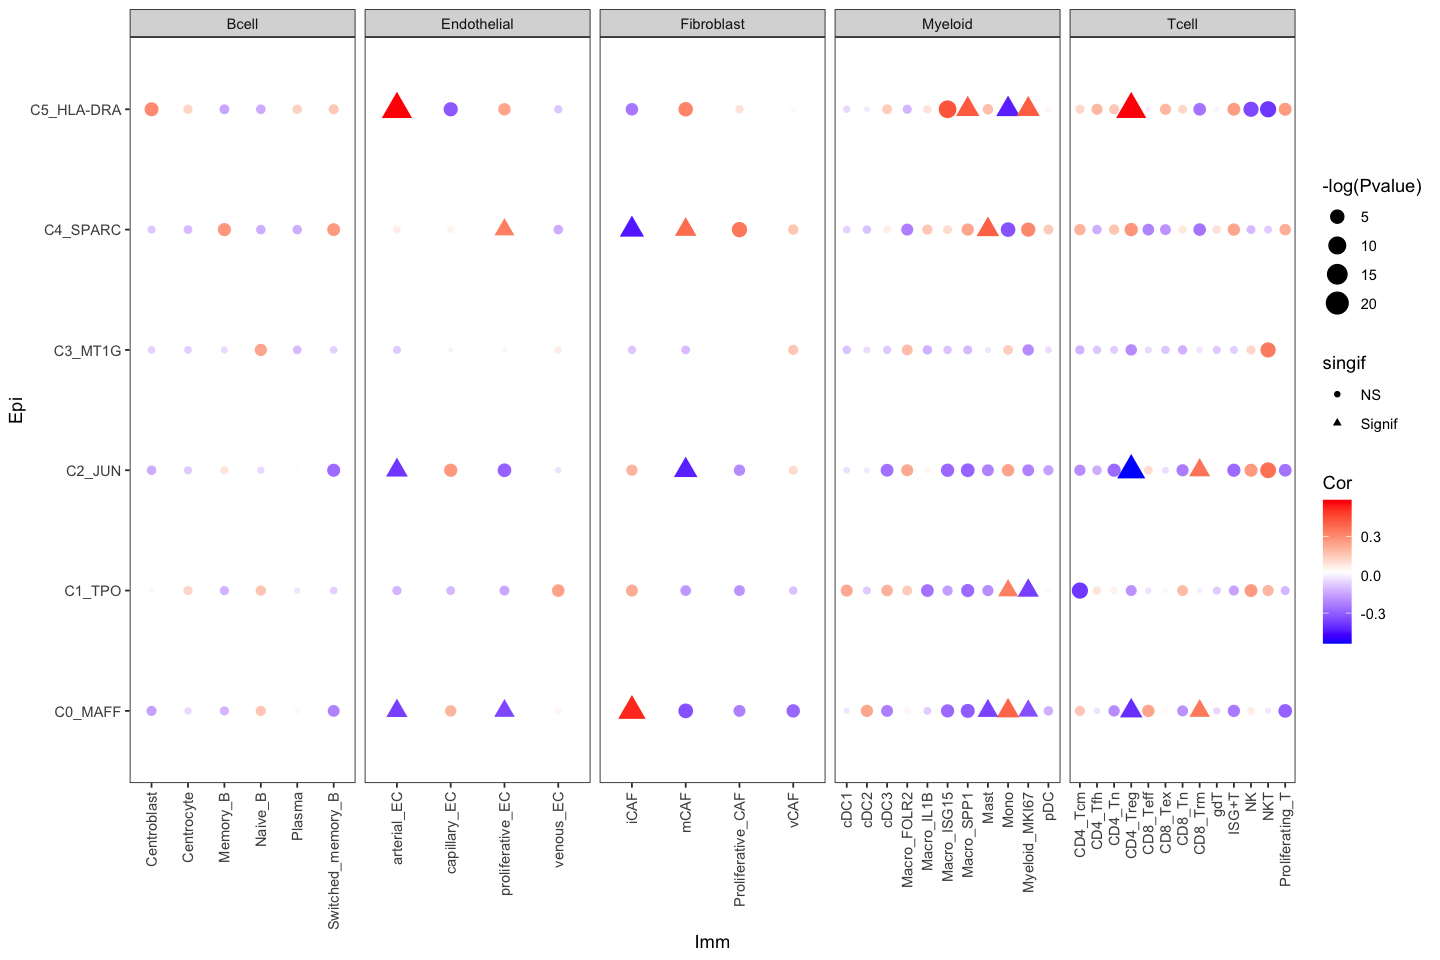

In [54]:

Epi_Imm_cor%>%
  filter(Cluster!='LEC') %>%
  #filter(Epi%in%c('C5_HLA-DRA', 'C4_SPARC')) %>%
  ggplot(aes(x=Imm, y=Epi, size=-log(Pvalue), color=Cor, shape=singif))+
  geom_point()+
  scale_color_gradientn(colours = c('blue', 'white', 'red'))+#, limits=c(-1,1))+
  facet_wrap(~Cluster, scales = 'free_x', nrow=1)+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 90, hjust = 1,vjust = 0.5))


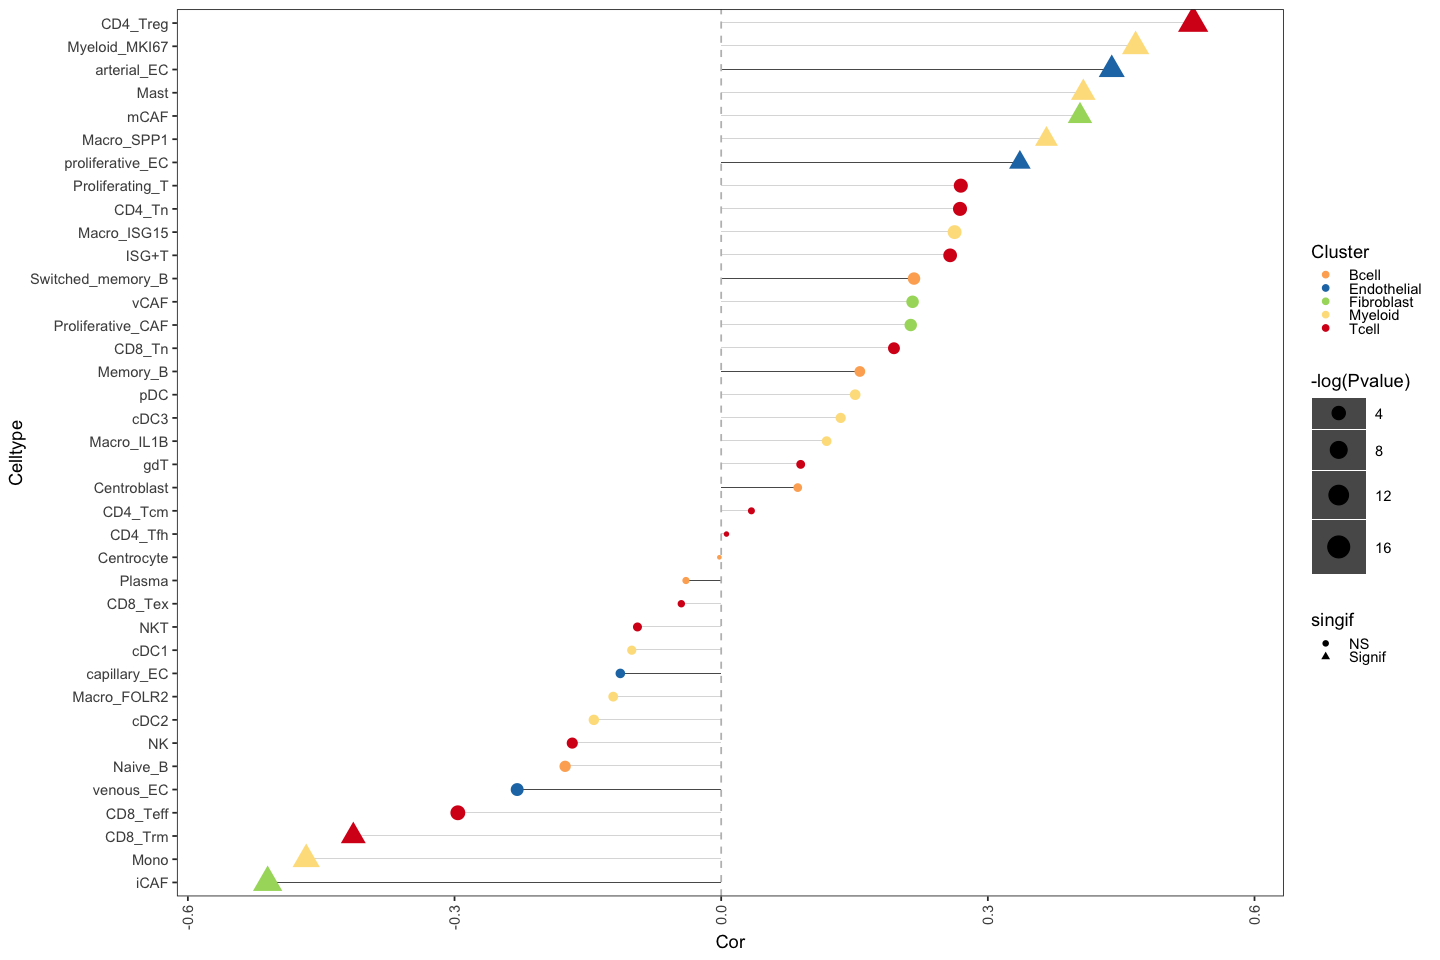

In [55]:
b=mal_cor%>%
  filter(Cluster!='LEC') %>%
  filter(Cluster!='Epithelial') %>%
  mutate(Celltype=fct_reorder(Celltype, Cor)) %>%
  #filter(Epi%in%c('C5_HLA-DRA', 'C4_SPARC')) %>%
  ggplot(aes(x=Celltype, y=Cor, size=-log(Pvalue), color=Cluster, shape=singif))+
  geom_col(width=0.01, color=NA)+
  geom_point()+
  geom_hline(yintercept = 0, color='gray', linetype='dashed')+
  scale_color_manual(values = all_subtype_colors)+
  #scale_color_igv()+
  #scale_color_gradientn(colours = c('blue', 'white', 'red'))+#, limits=c(-1,1))+
  #facet_wrap(~Cluster, scales = 'free_x', nrow=1)+
  scale_y_continuous(expand = c(0.05,0.05))+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 90, hjust = 1,vjust = 0.5),
        legend.key.height = unit(1,'mm'))+
  coord_flip()
b

In [56]:
signif_cell = mal_cor%>%
  filter(Cluster!='LEC') %>%
  filter(Cluster!='Epithelial') %>%
  filter(Celltype!='Endothelial') %>%
  filter(singif=='Signif')

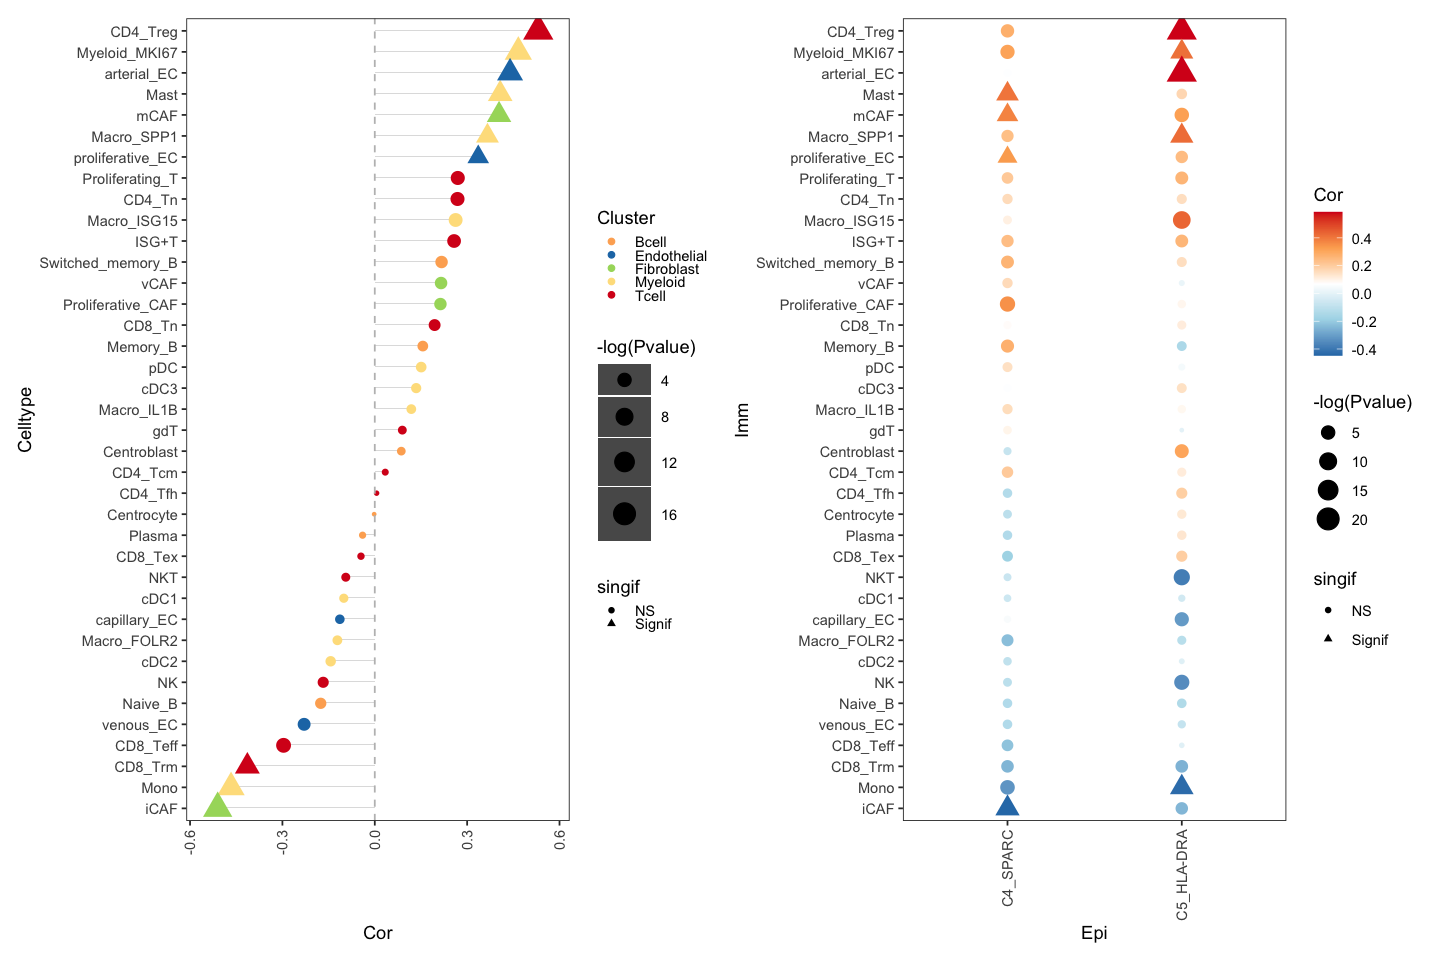

In [58]:
a=Epi_Imm_cor%>%
  filter(Cluster!='LEC') %>%
  filter(Imm!='Endothelial') %>%
  filter(Epi%in%c('C5_HLA-DRA', 'C4_SPARC')) %>%
  mutate(Imm=factor(Imm, levels=levels(b$data$Celltype))) %>%
  ggplot(aes(x=Imm, y=Epi, size=-log(Pvalue), color=Cor, shape=singif))+
  geom_point()+
  scale_color_gradientn(colours = c('#2C7BB6','#ABD9E9','#FFFFFF','#FDAE61','#D7191C'))+#, limits=c(-1,1))+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 90, hjust = 1,vjust = 0.5))+
  coord_flip()

b+a

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


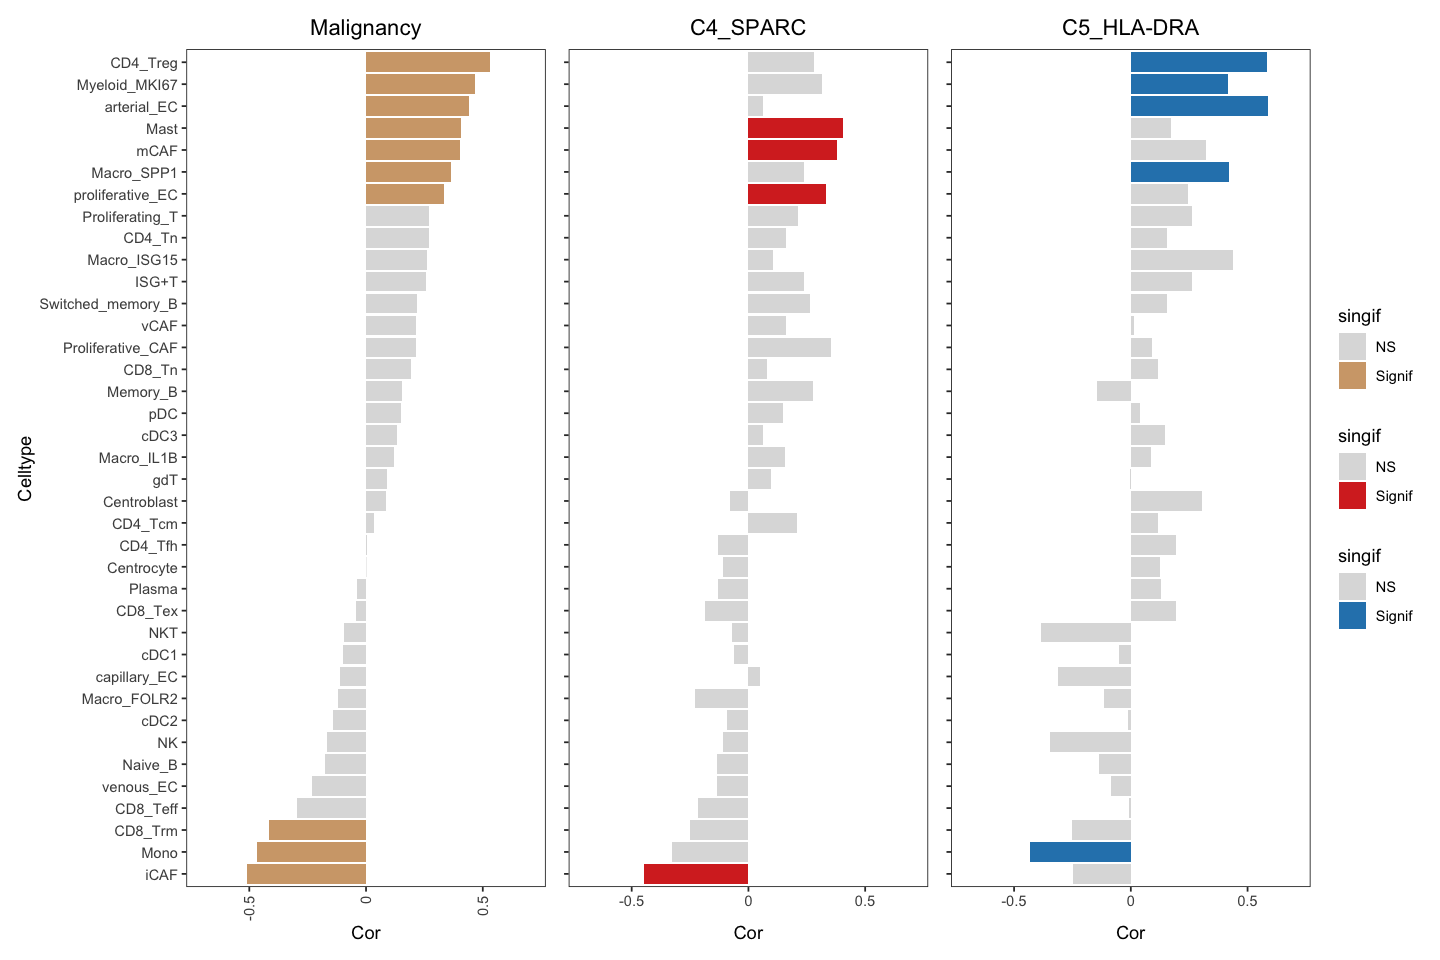

In [59]:
b1=mal_cor%>%
  filter(Cluster!='LEC') %>%
  filter(Cluster!='Epithelial') %>%
  mutate(Celltype=fct_reorder(Celltype, Cor)) %>%
  #filter(Epi%in%c('C5_HLA-DRA', 'C4_SPARC')) %>%
  ggplot(aes(x=Celltype, y=Cor, fill=singif))+
  geom_bar(stat='identity')+
  scale_fill_manual(values = c('NS'='#dddddd','Signif'='#D1A679'))+#, limits=c(-1,1))+
  #geom_hline(yintercept = 0, color='gray', linetype='dashed')+
  scale_color_manual(values = all_subtype_colors)+
  #scale_color_igv()+
  #scale_color_gradientn(colours = c('blue', 'white', 'red'))+#, limits=c(-1,1))+
  #facet_wrap(~Cluster, scales = 'free_x', nrow=1)+
  labs(title='Malignancy')+
  theme_bw()+
  scale_y_continuous(breaks = c(-0.5,0,0.5), labels = c(-0.5,0,0.5),limits=c(-0.7,0.7))+
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 90, hjust = 1,vjust = 0.5),
        plot.title = element_text(hjust=0.5)
        #legend.key.height = unit(1,'mm')
        )+
  coord_flip()
a1=Epi_Imm_cor%>%
  filter(Cluster!='LEC') %>%
  filter(Imm!='Endothelial') %>%
  filter(Epi%in%c('C4_SPARC')) %>%
  mutate(Imm=factor(Imm, levels=levels(b$data$Celltype))) %>%
  ggplot(aes(x=Imm, y=Cor, fill=singif))+
  geom_bar(stat='identity')+
  #scale_fill_gradientn(colours = c('#2C7BB6','#ABD9E9','#FDAE61','#D7191C'))+#, limits=c(-1,1))+
  scale_fill_manual(values = c('NS'='#dddddd','Signif'='#D73027'))+#, limits=c(-1,1))+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.text.y = element_blank(),
        plot.title = element_text(hjust=0.5),
        axis.title.y = element_blank())+
  scale_y_continuous(breaks = c(-0.5,0,0.5), labels = c(-0.5,0,0.5),limits=c(-0.7,0.7))+
  labs(title='C4_SPARC')+
  coord_flip()
a2=Epi_Imm_cor%>%
  filter(Cluster!='LEC') %>%
  filter(Imm!='Endothelial') %>%
  filter(Epi%in%c('C5_HLA-DRA')) %>%
  mutate(Imm=factor(Imm, levels=levels(b$data$Celltype))) %>%
  ggplot(aes(x=Imm, y=Cor, fill=singif))+
  geom_bar(stat='identity')+
  #scale_fill_gradientn(colours = c('#2C7BB6','#ABD9E9','#FDAE61','#D7191C'))+#, limits=c(-1,1))+
  scale_fill_manual(values = c('NS'='#dddddd','Signif'='#2B83BA'))+#, limits=c(-1,1))+
  theme_bw()+
  scale_y_continuous(breaks = c(-0.5,0,0.5), labels = c(-0.5,0,0.5),limits=c(-0.7,0.7))+
  labs(title='C5_HLA-DRA')+
  theme(panel.grid = element_blank(),
        axis.text.y = element_blank(),
        plot.title = element_text(hjust=0.5),
        axis.title.y = element_blank())+
  coord_flip()

aa = (b1|a1|a2) + patchwork::plot_layout(guides = 'collect')
aa

In [60]:
ggsave(glue('{output_dir}/亚型与轨迹及C4C5相关性barplot.pdf'),aa,
       width=6, height = 6, units='in', dpi = 450, bg = 'transparent')

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 14 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 14 rows containing non-finite outside the scale range (`stat_cor()`).”
Warning message:
“Removed 14 rows containing missing values or values outside the scale range
(`geom_point()`).”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 14 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 14 rows containing non-finite outside the scale range (`stat_cor()`).”
Warning message:
“Removed 14 rows containing missing values or values outside the scale range
(`geom_point()`).”


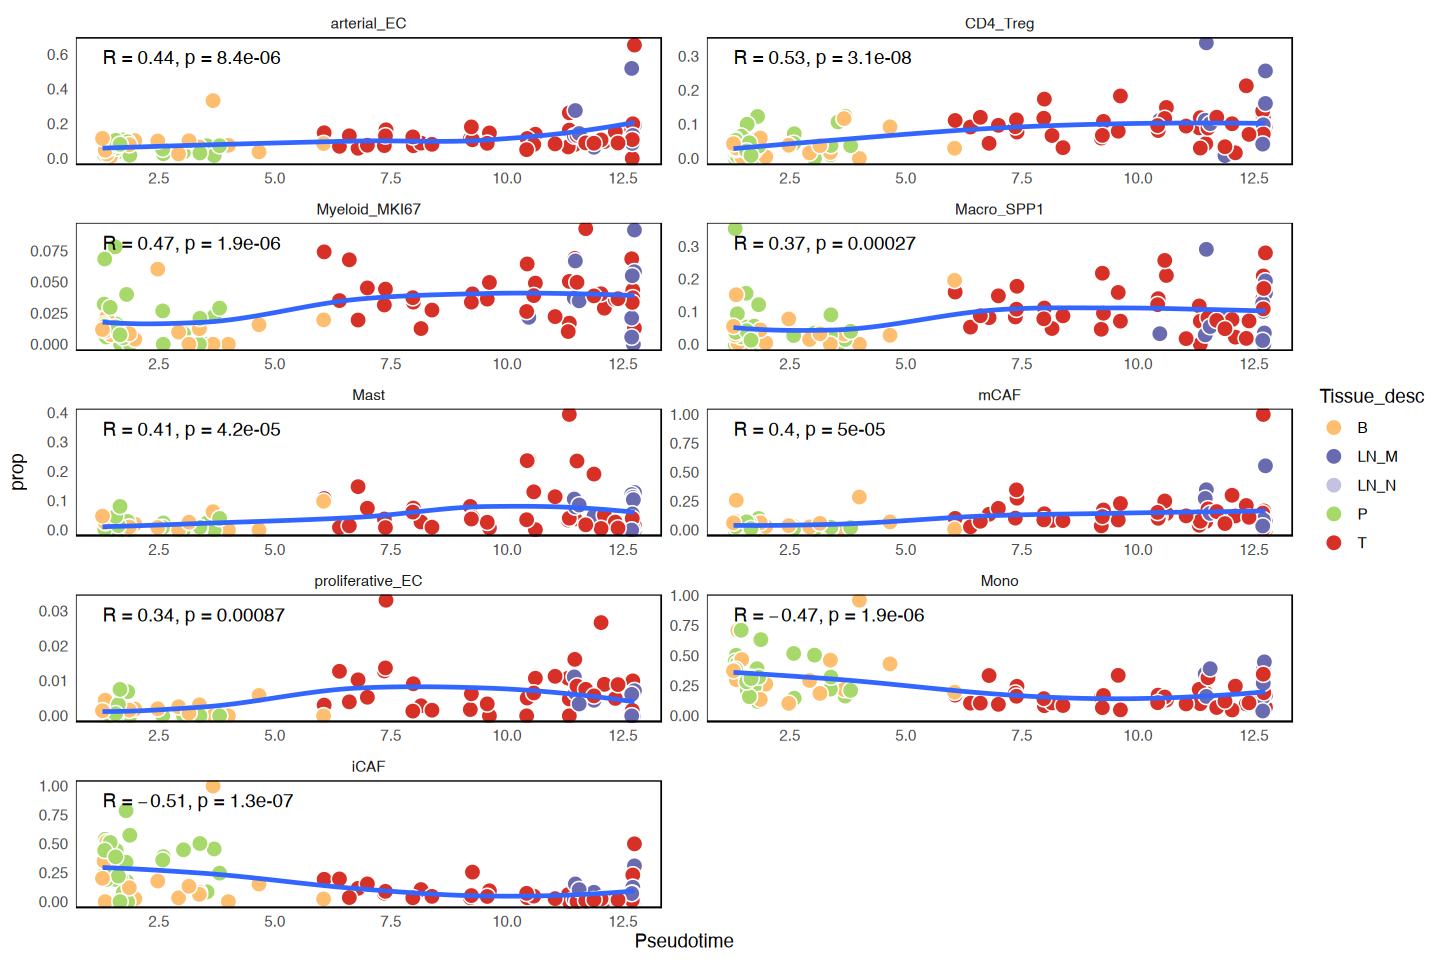

In [73]:
signif_cell_show = c('arterial_EC', 'CD4_Treg', 'Myeloid_MKI67','Macro_SPP1','Mast', 'mCAF','proliferative_EC', 'Mono', 'iCAF')
a=other_prop3 %>%
  #filter(Tissue_desc=='T') %>%
  #filter(Coexisting_HT=='No') %>%
  filter(sub_cluster%in%signif_cell_show) %>%
  mutate(sub_cluster=factor(sub_cluster, signif_cell_show)) %>%
  ggplot(aes(x=Pseudotime, y=prop)) +
  geom_point(aes(fill=Tissue_desc),size=4, shape=21, color='white') +
  #scale_fill_igv()+
  scale_fill_manual(values = tissue_colors)+
  geom_smooth(se=F)+
  stat_cor()+
  facet_wrap(~sub_cluster, nrow=5, scales = 'free')+
  theme_minimal()+
  theme(panel.border = element_rect(color='black', fill=NA),
        panel.grid = element_blank())
a

ggsave(glue('{output_dir}/显著细胞类型scatter_plot.pdf'),a,
       width=6, height = 10, units='in', dpi = 450, bg = 'transparent')

Joining with `by = join_by(orig.ident, C4_Prop)`


Joining with `by = join_by(orig.ident, C5_Prop)`
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 6 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 6 rows containing non-finite outside the scale range (`stat_cor()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 6 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 6 rows containing non-finite outside the scale range (`stat_cor()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”


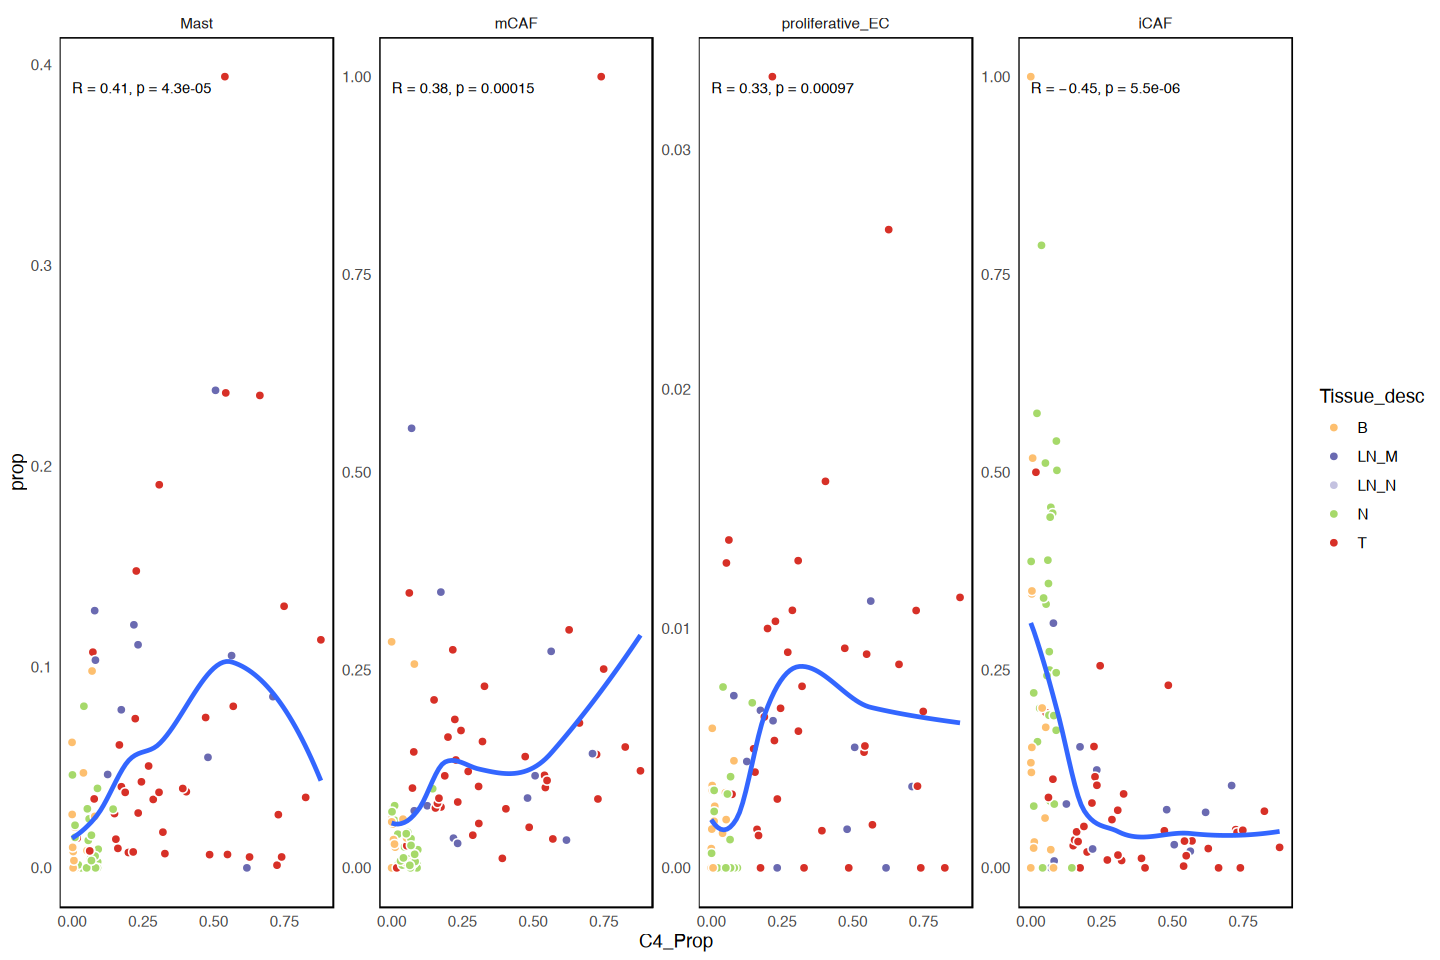

In [74]:
other_prop3_C4 = other_prop3[other_prop3$sub_cluster=='C4_SPARC',c('orig.ident', 'prop')]
colnames(other_prop3_C4) = c('orig.ident', 'C4_Prop')
other_prop3_C5 = other_prop3[other_prop3$sub_cluster=='C5_HLA-DRA',c('orig.ident', 'prop')]
colnames(other_prop3_C5) = c('orig.ident', 'C5_Prop')
other_prop3 = left_join(other_prop3,other_prop3_C4)
other_prop3 = left_join(other_prop3,other_prop3_C5)

signif_cell_show = c('Mast', 'mCAF','proliferative_EC', 'iCAF')

other_prop3_2 = other_prop3
other_prop3_2$Tissue_desc[other_prop3_2$Tissue_desc=='P'] = 'N'
a=other_prop3_2 %>%
  filter(sub_cluster%in%signif_cell_show) %>%
  mutate(sub_cluster=factor(sub_cluster,signif_cell_show)) %>%
  ggplot(aes(x=C4_Prop, y=prop))+
  geom_point(aes(fill=Tissue_desc),size=2, shape=21, color='white') +
  scale_fill_manual(values = tissue_colors)+
  geom_smooth(se=F)+
  stat_cor(,size=3)+
  facet_wrap(~sub_cluster, nrow=1, scales = 'free')+
  theme_minimal()+
  theme(panel.border = element_rect(color='black', fill=NA),
        panel.grid = element_blank())
a
ggsave(glue('{output_dir}/显著细胞类型C4与免疫scatter_plot.pdf'),a,
       width=180, height = 60, units='mm', dpi = 450, bg = 'transparent')

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_cor()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_cor()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”


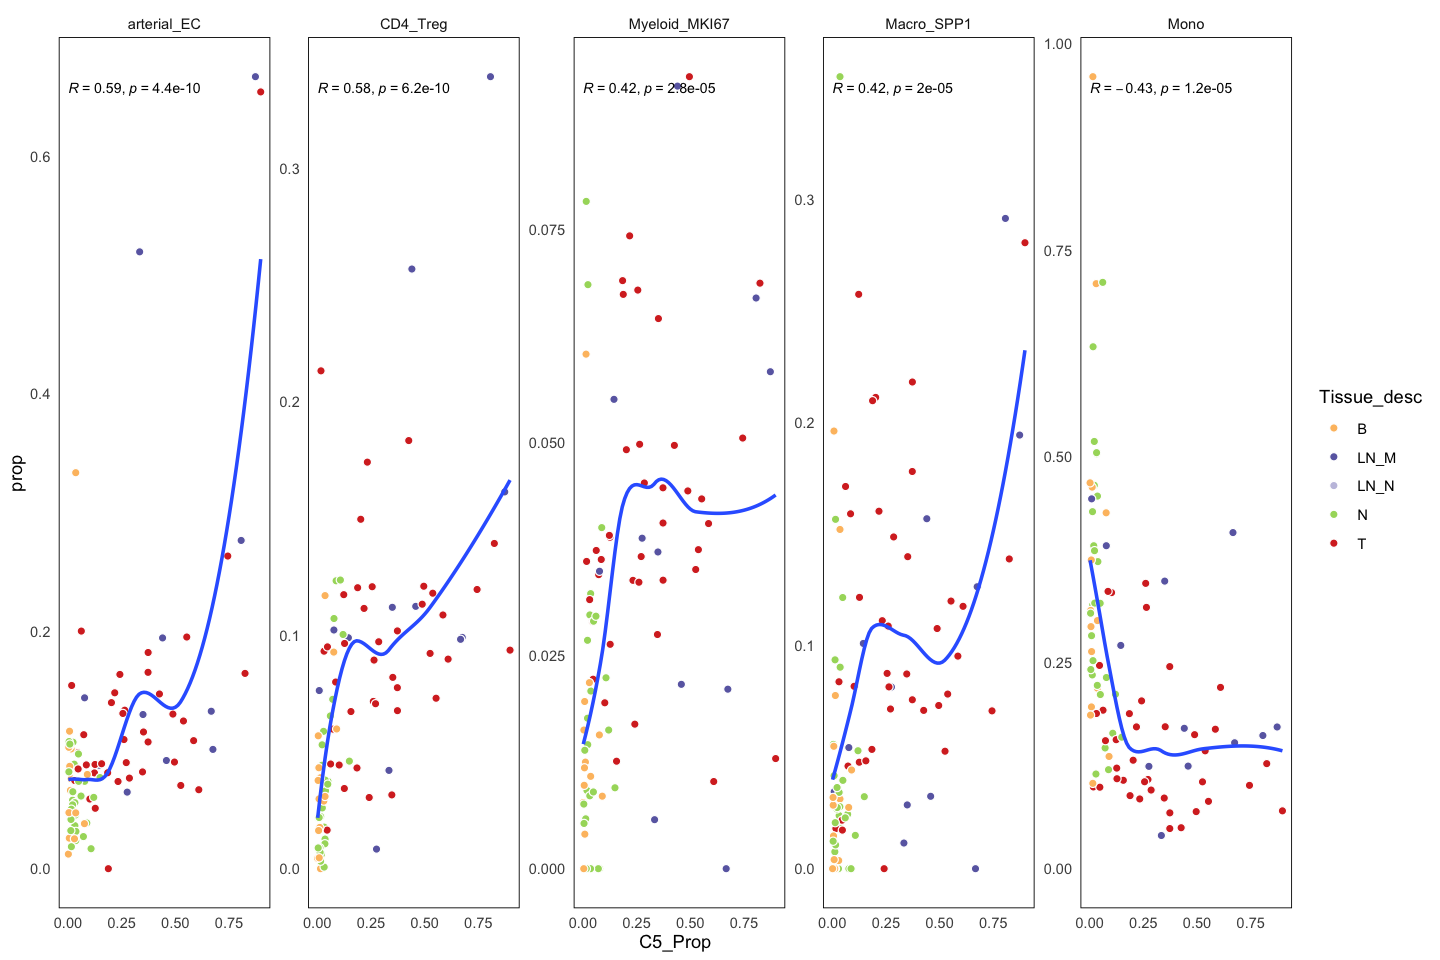

In [71]:
signif_cell_show = c('arterial_EC', 'CD4_Treg', 'Myeloid_MKI67','Macro_SPP1', 'Mono')

other_prop3_2 = other_prop3
other_prop3_2$Tissue_desc[other_prop3_2$Tissue_desc=='P'] = 'N'
b=other_prop3_2 %>%
  filter(sub_cluster%in%signif_cell_show) %>%
  mutate(sub_cluster=factor(sub_cluster,signif_cell_show)) %>%
  ggplot(aes(x=C5_Prop, y=prop))+
  geom_point(aes(fill=Tissue_desc),size=2, shape=21, color='white') +
  scale_fill_manual(values = tissue_colors)+
  geom_smooth(se=F)+
  stat_cor(,size=3)+
  facet_wrap(~sub_cluster, nrow=1, scales = 'free')+
  theme_minimal()+
  theme(panel.border = element_rect(color='black', fill=NA),
        panel.grid = element_blank())
b
ggsave(glue('{output_dir}/显著细胞类型C5与免疫scatter_plot.pdf'),b,
       width=300, height =60, units='mm', dpi = 450, bg = 'transparent')


Warning message:
“The dot-dot notation (`..r.label..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(r.label)` instead.”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_cor()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_cor()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 8 rows c

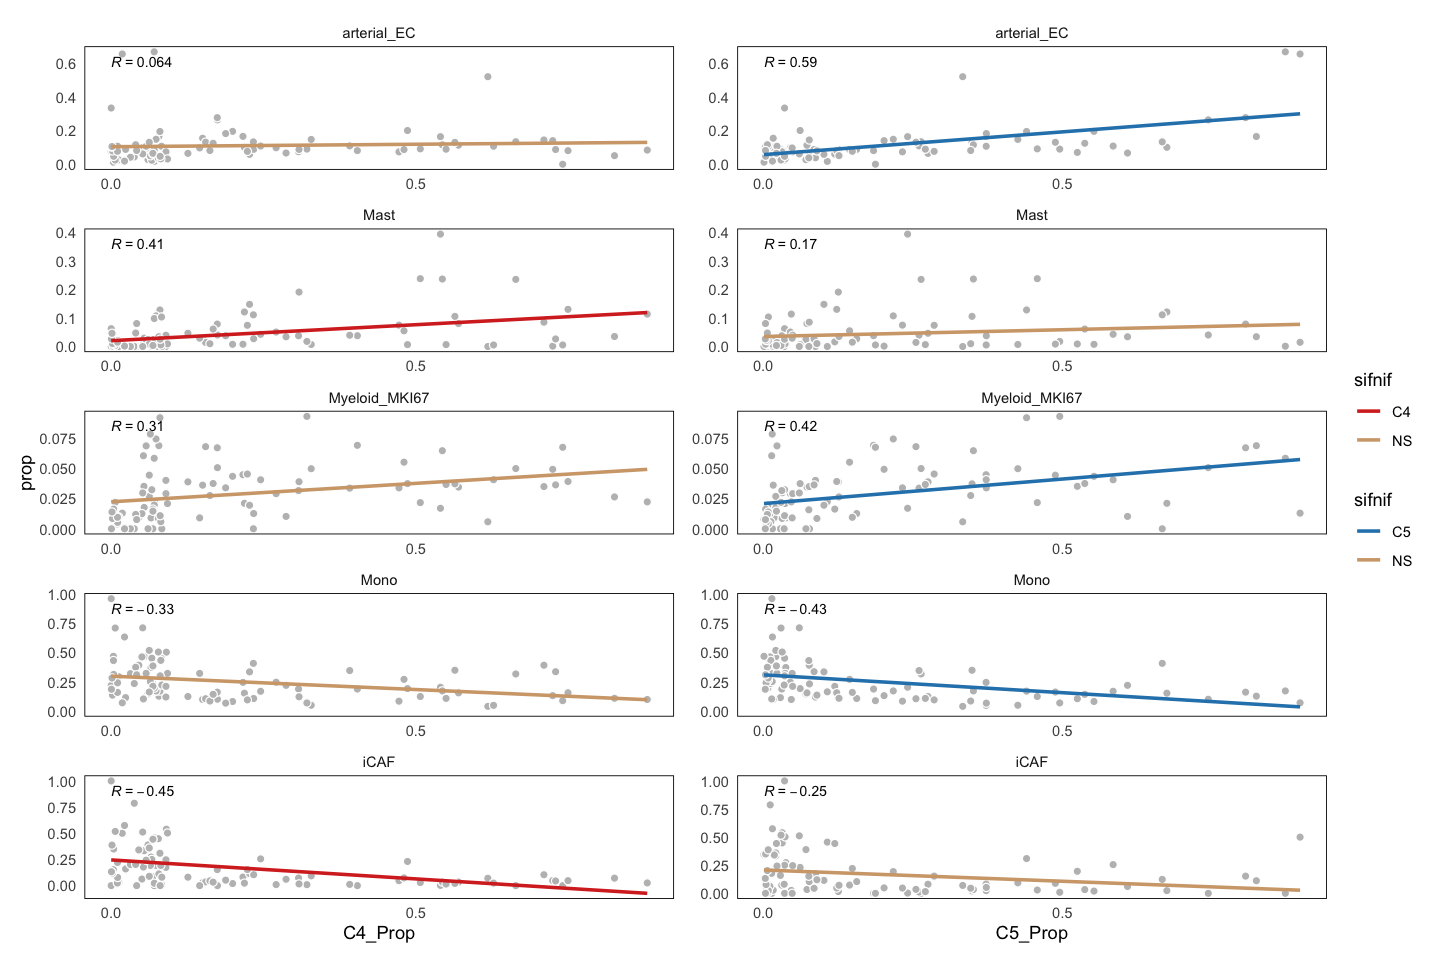

In [64]:
a=other_prop3_2 %>%
  filter(sub_cluster%in%signif_cell_show) %>%
  mutate(sub_cluster=factor(sub_cluster,signif_cell_show)) %>%
  ggplot(aes(x=C4_Prop, y=prop))+
  geom_point(,size=2, shape=21, color='white', fill='gray') +
  geom_smooth(aes(color=ifelse(sub_cluster%in%c('Mast', 'iCAF'), 'C4','NS')),se=F, method='glm')+
  stat_cor(aes(label=..r.label..),size=3)+
  scale_color_manual(values = c('NS'='#D1A679','C4'='#D73027'), name='sifnif')+
  facet_wrap(~sub_cluster, ncol=1, scales = 'free')+
  scale_x_continuous(breaks = c(0,0.5,1))+
  theme_minimal()+
  theme(panel.border = element_rect(color='black', fill=NA),
        panel.grid = element_blank())
b=other_prop3 %>%
  filter(sub_cluster%in%signif_cell_show) %>%
  mutate(sub_cluster=factor(sub_cluster,signif_cell_show)) %>%
  ggplot(aes(x=C5_Prop, y=prop))+
  geom_point(aes(),size=2, shape=21, color='white', fill='gray') +
  geom_smooth(aes(color=ifelse(!sub_cluster%in%c('Mast', 'iCAF'), 'C5','NS')),se=F, method='glm')+
  stat_cor(aes(label=..r.label..),size=3)+
  scale_color_manual(values = c('NS'='#D1A679','C5'='#2B83BA'), name='sifnif')+
  facet_wrap(~sub_cluster, ncol=1, scales = 'free')+
  scale_x_continuous(breaks = c(0,0.5,1))+
  theme_minimal()+
  theme(panel.border = element_rect(color='black', fill=NA),
        panel.grid = element_blank(),
        axis.title.y = element_blank())
c = (a|b)+patchwork::plot_layout(guides = 'collect')
c
ggsave(glue('{output_dir}/显著细胞类型C4C5与免疫scatter_plot.pdf'),c,
       width=120, height =280, units='mm', dpi = 450, bg = 'transparent')